## Imports

In [1]:
import time
import json
import matplotlib.pyplot as plt
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from PIL import Image

import numpy as np
import matplotlib.patches as patches
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.map import MeanAveragePrecision

import pycocotools

In [3]:
# imports from local lib files
import utils
import transforms
import coco_eval
from engine import train_one_epoch, evaluate

## File paths

In [4]:
output_path = 'output'
img_folder = 'eccv_18_all_images_sm'

cis_test_ann_path = 'eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path = 'eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = 'eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path = 'eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = 'eccv_18_annotation_files/trans_val_annotations.json'

## Basic data exploration

In [5]:
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann = json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

In [77]:
print('cis test set length:', len(cis_test_ann['images']))
print('cis val set length:', len(cis_val_ann['images']))
print('train set length:', len(train_ann['images']))
print('trans test set length:', len(trans_test_ann['images']))
print('trans val set length:', len(trans_val_ann['images']))

cis test set length: 15827
cis val set length: 3484
train set length: 13553
trans test set length: 23275
trans val set length: 1725


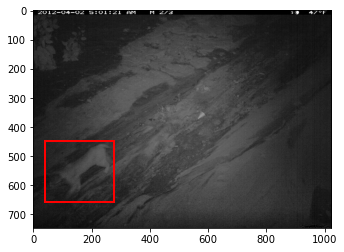

In [76]:
i = 500

boxes = [trans_val_ann['annotations'][j]['bbox'] for j in range(len(trans_val_ann['annotations'])) 
         if trans_val_ann['annotations'][j]['image_id']==trans_val_ann['images'][i]['id'] 
         and 'bbox' in trans_val_ann['annotations'][j].keys()]

img_path = os.path.join('eccv_18_all_images_sm', trans_val_ann['images'][i]['file_name']) # to change

image = read_image(img_path)

fig, ax = plt.subplots()
ax.imshow(image[0].squeeze(),cmap="gray")

scale_x = image.shape[2] / trans_val_ann['images'][i]['width'] 
scale_y = image.shape[1] / trans_val_ann['images'][i]['height']

boxes = torch.as_tensor(boxes)

for i in range(boxes.shape[0]):
    boxes[i][0] = torch.round(boxes[i][0] * scale_x)
    boxes[i][1] = torch.round(boxes[i][1] * scale_y)
    boxes[i][2] = torch.round(boxes[i][2] * scale_x)
    boxes[i][3] = torch.round(boxes[i][3] * scale_y)

    boxes[i][2] = boxes[i][0] + boxes[i][2]
    boxes[i][3] = boxes[i][1] + boxes[i][3]

target = {}
target["boxes"] = boxes

rect = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2]-boxes[0][0], 
                         boxes[0][3]-boxes[0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

## Utils

In [20]:
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from git hub repo

data_transform = {'train': T.RandomHorizontalFlip(0.5)}

In [21]:
# Returns a list with the idx of images with at least one bounding box (img_wbbox) and a 
# list with the number of bbox for each valid image (num_bbox)
def get_img_with_bbox(file_path):
  
    file = json.load(open(file_path))
    img_wbbox = []
    num_bbox = []

    for i in range(len(file['images'])):
        bboxes = [file['annotations'][j]['bbox'] 
                  for j in range(len(file['annotations'])) 
                  if file['annotations'][j]['image_id']==file['images'][i]['id'] 
                  and 'bbox' in file['annotations'][j].keys()]

        if len(bboxes)!=0:
            img_wbbox.append(i)

            num_bbox.append(len(bboxes))

    return img_wbbox, num_bbox

In [22]:
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform = None, target_transform=None):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.valid_img = valid_img

    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx = self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv = torchvision.transforms.ToTensor()
        # if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image = conv(image)

        boxes = [self.label_file['annotations'][j]['bbox'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        
        label = [self.label_file['annotations'][j]['category_id'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x = image.shape[2] / self.label_file['images'][idx]['width'] 
        scale_y = image.shape[1] / self.label_file['images'][idx]['height']

        boxes = torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
            boxes[i][0] = torch.round(boxes[i][0] * scale_x)
            boxes[i][1] = torch.round(boxes[i][1] * scale_y)
            boxes[i][2] = torch.round(boxes[i][2] * scale_x)
            boxes[i][3] = torch.round(boxes[i][3] * scale_y)

            boxes[i][2] = boxes[i][0] + boxes[i][2] # to transform to pytorch bbox format
            boxes[i][3] = boxes[i][1] + boxes[i][3]

            #boxes[i][0]*=scale_x
            #boxes[i][1]*=scale_y
            #boxes[i][2]*=scale_x
            #boxes[i][3]*=scale_y

        label = torch.as_tensor(label)
        label = torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd

        # TO DO : resize all to same size

        if self.transform:
            # transform image AND target
            image, target = self.transform(image, target)
        if self.target_transform:
            label = self.target_transform(label)

        return image, target

## Pre-trained models

In [27]:
# Inspired from https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YjNHjVMOyYlH

### Model with last layer to train

In [ ]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### Model with more layers to train

In [28]:
# def get_model_from_pretrained(num_classes):

#     # load an instance segmentation model pre-trained on COCO
#     model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

#     for param in model.parameters(): # to freeze all existing weights
#         param.requires_grad = False

#     for param in model.roi_heads.parameters():
#         param.requires_grad = True
    
#     for param in model.

#     # get the number of input features for the classifier
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     return model

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

# like in the paper, construct the scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

### Create the dataloaders
To load the data of the dataset efficiently for the model

In [30]:
train_valid_img,_ = get_img_with_bbox(train_ann_path)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

In [31]:
trans_val_valid_img,_ = get_img_with_bbox(trans_val_ann_path)   # takes about 1min to run on train data
trans_valid_data = CustomImageDataset(trans_val_ann_path,img_folder, trans_val_valid_img)
trans_valid_dataloader = DataLoader(trans_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [32]:
cis_val_valid_img,_ = get_img_with_bbox(cis_val_ann_path)   # takes about 1min to run on train data
cis_valid_data = CustomImageDataset(cis_val_ann_path,img_folder, cis_val_valid_img)
cis_valid_dataloader = DataLoader(cis_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

## Loading/Importing a model
#### Need to initiate the model, the optimizer and de scheduler before loading

In [ ]:
# NEED TO INITIATE THE MODEL, THE OPTIMIZER AND THE SCHEDULER BEFOREHAND (if )
# load the model, the optimizer and the scheduler
model.load_state_dict(torch.load('saved_data/model.pt'))
optimizer.load_state_dict(torch.load('saved_data/optimizer.pt'))
lr_scheduler.load_state_dict(torch.load('saved_data/scheduler.pt'))
model.eval()

## Logs utils

#### Train logs utils

In [257]:
import time

In [258]:
# Converts the smoothed values to a dictionnary of each values
def smoothed_value_to_str(smoothed_value):
    d_values = {}
    d_values['median'] = smoothed_value.median
    d_values['avg'] = smoothed_value.avg
    d_values['global_avg'] = smoothed_value.global_avg
    d_values['max'] = smoothed_value.max
    d_values['value'] = smoothed_value.value
    return d_values

In [259]:
# Converts the train logs from MetricLogger to string
def metric_logger_to_str(logs):
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].meters.keys():
            d[key] = smoothed_value_to_str(logs[i].meters[key])
        lst.append(d)
    return lst

In [260]:
# Puts the training logs into a json file with time dependent file name
def train_logs_to_json(logs):
    train_metric_logs = metric_logger_to_str(logs)
    filename = time.strftime("%Y%m%d_%H%M%S") + "_train_logs"
    
    with open('jsons/' + filename, 'w', encoding='utf-8') as f:
        json.dump(train_metric_logs, f, ensure_ascii=False, indent=4)

#### Valid logs utils

In [261]:
# Merge the dicts of a list 
def merge_dict(logs):
    logs_better = []
    try:
        for i in range(len(logs)):
            logs_better.append({**logs[i][0], **logs[i][1], **logs[i][2], **logs[i][3]})
        return logs_better
    except:
        print(logs[0])
        logs_better = logs
        return logs_better

In [262]:
# Converts the valid logs from list of dictionnaries to string
def valid_logs_to_str(valid_logs):
    logs = merge_dict(valid_logs)
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].keys():
            d[key] = logs[i][key].cpu().numpy().tolist()
        lst.append(d)
    return lst

In [270]:
# Puts the cis validation logs into a json file with time dependent file name
def cis_valid_logs_to_json(logs):
    valid_metric_logs = valid_logs_to_str(logs)
    filename = time.strftime("%Y%m%d_%H%M%S") + "_cis_valid_logs"
    
    with open('jsons/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

In [271]:
# Puts the trans validation logs into a json file with time dependent file name
def trans_valid_logs_to_json(logs):
    valid_metric_logs = valid_logs_to_str(logs)
    filename = time.strftime("%Y%m%d_%H%M%S") + "_trans_valid_logs"
    
    with open('jsons/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

## Training the model

In [265]:
# PARAMETERS TO TUNE BEFORE TRAINING
num_epochs = 15

In [266]:
# CHECK DEVICE BEFORE TRAINING
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

In [111]:
# TRAIN

all_train_logs = []
all_cis_valid_logs = []
all_trans_valid_logs = []

for epoch in range(num_epochs):
    # train for one epoch, printing every 100 images
    train_logs = train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=100)
    all_train_logs.append(train_logs)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset after training one epoch

    for images, targets in trans_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            trans_loss_dict = model(images, targets)
            trans_loss_dict = [{k: loss.to('cpu')} for k, loss in trans_loss_dict.items()]
            all_trans_valid_logs.append(trans_loss_dict)


    for images, targets in cis_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            cis_loss_dict = model(images, targets)
            cis_loss_dict = [{k: loss.to('cpu')} for k, loss in cis_loss_dict.items()]
            all_cis_valid_logs.append(cis_loss_dict)


train_logs_to_json(all_train_logs)
cis_valid_logs_to_json(all_cis_valid_logs)
trans_valid_logs_to_json(all_trans_valid_logs)

Epoch: [0]  [    0/12099]  eta: 0:27:01  lr: 0.000000  loss: 0.1575 (0.1575)  loss_classifier: 0.0253 (0.0253)  loss_box_reg: 0.0346 (0.0346)  loss_objectness: 0.0945 (0.0945)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 0.1340  data: 0.0300  max mem: 4059
Epoch: [0]  [  100/12099]  eta: 0:23:19  lr: 0.000000  loss: 0.1150 (0.1153)  loss_classifier: 0.0230 (0.0282)  loss_box_reg: 0.0369 (0.0478)  loss_objectness: 0.0147 (0.0331)  loss_rpn_box_reg: 0.0035 (0.0061)  time: 0.1150  data: 0.0293  max mem: 4059
Epoch: [0]  [  200/12099]  eta: 0:23:00  lr: 0.000001  loss: 0.0818 (0.1130)  loss_classifier: 0.0173 (0.0277)  loss_box_reg: 0.0427 (0.0457)  loss_objectness: 0.0037 (0.0309)  loss_rpn_box_reg: 0.0016 (0.0087)  time: 0.1132  data: 0.0285  max mem: 4059
Epoch: [0]  [  300/12099]  eta: 0:22:42  lr: 0.000001  loss: 0.0980 (0.1130)  loss_classifier: 0.0182 (0.0274)  loss_box_reg: 0.0363 (0.0453)  loss_objectness: 0.0143 (0.0312)  loss_rpn_box_reg: 0.0026 (0.0091)  time: 0.1138  data: 0.0287

Epoch: [0]  [ 3300/12099]  eta: 0:16:41  lr: 0.000003  loss: 0.1182 (0.1144)  loss_classifier: 0.0238 (0.0273)  loss_box_reg: 0.0396 (0.0458)  loss_objectness: 0.0185 (0.0334)  loss_rpn_box_reg: 0.0031 (0.0079)  time: 0.1153  data: 0.0298  max mem: 4059
Epoch: [0]  [ 3400/12099]  eta: 0:16:30  lr: 0.000003  loss: 0.0713 (0.1137)  loss_classifier: 0.0181 (0.0272)  loss_box_reg: 0.0296 (0.0457)  loss_objectness: 0.0042 (0.0330)  loss_rpn_box_reg: 0.0015 (0.0079)  time: 0.1142  data: 0.0294  max mem: 4059
Epoch: [0]  [ 3500/12099]  eta: 0:16:18  lr: 0.000003  loss: 0.1049 (0.1135)  loss_classifier: 0.0237 (0.0272)  loss_box_reg: 0.0455 (0.0457)  loss_objectness: 0.0139 (0.0327)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1136  data: 0.0298  max mem: 4059
Epoch: [0]  [ 3600/12099]  eta: 0:16:07  lr: 0.000003  loss: 0.0809 (0.1134)  loss_classifier: 0.0216 (0.0272)  loss_box_reg: 0.0471 (0.0458)  loss_objectness: 0.0069 (0.0326)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1135  data: 0.0293

Epoch: [0]  [ 6600/12099]  eta: 0:10:24  lr: 0.000003  loss: 0.1065 (0.1142)  loss_classifier: 0.0222 (0.0272)  loss_box_reg: 0.0417 (0.0459)  loss_objectness: 0.0180 (0.0332)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1127  data: 0.0283  max mem: 4059
Epoch: [0]  [ 6700/12099]  eta: 0:10:13  lr: 0.000003  loss: 0.0907 (0.1140)  loss_classifier: 0.0190 (0.0272)  loss_box_reg: 0.0406 (0.0459)  loss_objectness: 0.0011 (0.0331)  loss_rpn_box_reg: 0.0015 (0.0078)  time: 0.1135  data: 0.0283  max mem: 4059
Epoch: [0]  [ 6800/12099]  eta: 0:10:02  lr: 0.000003  loss: 0.0938 (0.1141)  loss_classifier: 0.0235 (0.0272)  loss_box_reg: 0.0451 (0.0460)  loss_objectness: 0.0023 (0.0331)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1135  data: 0.0299  max mem: 4059
Epoch: [0]  [ 6900/12099]  eta: 0:09:50  lr: 0.000003  loss: 0.1259 (0.1141)  loss_classifier: 0.0188 (0.0272)  loss_box_reg: 0.0424 (0.0460)  loss_objectness: 0.0382 (0.0331)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1133  data: 0.0292

Epoch: [0]  [ 9900/12099]  eta: 0:04:09  lr: 0.000003  loss: 0.0943 (0.1139)  loss_classifier: 0.0166 (0.0270)  loss_box_reg: 0.0400 (0.0457)  loss_objectness: 0.0075 (0.0335)  loss_rpn_box_reg: 0.0016 (0.0078)  time: 0.1111  data: 0.0278  max mem: 4059
Epoch: [0]  [10000/12099]  eta: 0:03:57  lr: 0.000003  loss: 0.1110 (0.1140)  loss_classifier: 0.0207 (0.0270)  loss_box_reg: 0.0271 (0.0457)  loss_objectness: 0.0156 (0.0335)  loss_rpn_box_reg: 0.0048 (0.0078)  time: 0.1130  data: 0.0284  max mem: 4059
Epoch: [0]  [10100/12099]  eta: 0:03:46  lr: 0.000003  loss: 0.0674 (0.1139)  loss_classifier: 0.0179 (0.0270)  loss_box_reg: 0.0330 (0.0457)  loss_objectness: 0.0018 (0.0334)  loss_rpn_box_reg: 0.0011 (0.0078)  time: 0.1122  data: 0.0282  max mem: 4059
Epoch: [0]  [10200/12099]  eta: 0:03:35  lr: 0.000003  loss: 0.0988 (0.1138)  loss_classifier: 0.0248 (0.0269)  loss_box_reg: 0.0366 (0.0456)  loss_objectness: 0.0125 (0.0334)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1135  data: 0.0285

Epoch: [1]  [ 1000/12099]  eta: 0:20:54  lr: 0.000003  loss: 0.0941 (0.1136)  loss_classifier: 0.0185 (0.0271)  loss_box_reg: 0.0409 (0.0456)  loss_objectness: 0.0185 (0.0330)  loss_rpn_box_reg: 0.0036 (0.0078)  time: 0.1115  data: 0.0271  max mem: 4059
Epoch: [1]  [ 1100/12099]  eta: 0:20:45  lr: 0.000003  loss: 0.0738 (0.1131)  loss_classifier: 0.0184 (0.0270)  loss_box_reg: 0.0396 (0.0457)  loss_objectness: 0.0034 (0.0327)  loss_rpn_box_reg: 0.0015 (0.0077)  time: 0.1165  data: 0.0311  max mem: 4059
Epoch: [1]  [ 1200/12099]  eta: 0:20:34  lr: 0.000003  loss: 0.1178 (0.1134)  loss_classifier: 0.0236 (0.0269)  loss_box_reg: 0.0381 (0.0455)  loss_objectness: 0.0244 (0.0334)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1144  data: 0.0298  max mem: 4059
Epoch: [1]  [ 1300/12099]  eta: 0:20:23  lr: 0.000003  loss: 0.0725 (0.1139)  loss_classifier: 0.0218 (0.0271)  loss_box_reg: 0.0391 (0.0455)  loss_objectness: 0.0068 (0.0338)  loss_rpn_box_reg: 0.0025 (0.0075)  time: 0.1150  data: 0.0299

Epoch: [1]  [ 4300/12099]  eta: 0:14:44  lr: 0.000003  loss: 0.1110 (0.1147)  loss_classifier: 0.0194 (0.0270)  loss_box_reg: 0.0332 (0.0456)  loss_objectness: 0.0211 (0.0343)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1130  data: 0.0285  max mem: 4059
Epoch: [1]  [ 4400/12099]  eta: 0:14:33  lr: 0.000003  loss: 0.0932 (0.1147)  loss_classifier: 0.0225 (0.0270)  loss_box_reg: 0.0338 (0.0455)  loss_objectness: 0.0140 (0.0344)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1134  data: 0.0282  max mem: 4059
Epoch: [1]  [ 4500/12099]  eta: 0:14:21  lr: 0.000003  loss: 0.0928 (0.1148)  loss_classifier: 0.0194 (0.0270)  loss_box_reg: 0.0601 (0.0456)  loss_objectness: 0.0054 (0.0343)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1140  data: 0.0295  max mem: 4059
Epoch: [1]  [ 4600/12099]  eta: 0:14:10  lr: 0.000003  loss: 0.1019 (0.1148)  loss_classifier: 0.0246 (0.0270)  loss_box_reg: 0.0343 (0.0456)  loss_objectness: 0.0058 (0.0345)  loss_rpn_box_reg: 0.0035 (0.0078)  time: 0.1158  data: 0.0307

Epoch: [1]  [ 7600/12099]  eta: 0:08:29  lr: 0.000003  loss: 0.0935 (0.1148)  loss_classifier: 0.0192 (0.0271)  loss_box_reg: 0.0384 (0.0457)  loss_objectness: 0.0040 (0.0341)  loss_rpn_box_reg: 0.0021 (0.0079)  time: 0.1138  data: 0.0296  max mem: 4059
Epoch: [1]  [ 7700/12099]  eta: 0:08:18  lr: 0.000003  loss: 0.0867 (0.1148)  loss_classifier: 0.0227 (0.0271)  loss_box_reg: 0.0488 (0.0457)  loss_objectness: 0.0027 (0.0341)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1142  data: 0.0294  max mem: 4059
Epoch: [1]  [ 7800/12099]  eta: 0:08:07  lr: 0.000003  loss: 0.1166 (0.1148)  loss_classifier: 0.0198 (0.0271)  loss_box_reg: 0.0295 (0.0457)  loss_objectness: 0.0083 (0.0342)  loss_rpn_box_reg: 0.0033 (0.0079)  time: 0.1126  data: 0.0283  max mem: 4059
Epoch: [1]  [ 7900/12099]  eta: 0:07:55  lr: 0.000003  loss: 0.0676 (0.1146)  loss_classifier: 0.0166 (0.0271)  loss_box_reg: 0.0298 (0.0457)  loss_objectness: 0.0010 (0.0340)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1143  data: 0.0297

Epoch: [1]  [10900/12099]  eta: 0:02:15  lr: 0.000003  loss: 0.0885 (0.1140)  loss_classifier: 0.0223 (0.0269)  loss_box_reg: 0.0421 (0.0456)  loss_objectness: 0.0053 (0.0336)  loss_rpn_box_reg: 0.0042 (0.0078)  time: 0.1143  data: 0.0287  max mem: 4059
Epoch: [1]  [11000/12099]  eta: 0:02:04  lr: 0.000003  loss: 0.1268 (0.1140)  loss_classifier: 0.0258 (0.0269)  loss_box_reg: 0.0479 (0.0457)  loss_objectness: 0.0116 (0.0336)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1124  data: 0.0276  max mem: 4059
Epoch: [1]  [11100/12099]  eta: 0:01:53  lr: 0.000003  loss: 0.0761 (0.1140)  loss_classifier: 0.0199 (0.0269)  loss_box_reg: 0.0411 (0.0457)  loss_objectness: 0.0036 (0.0336)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1139  data: 0.0282  max mem: 4059
Epoch: [1]  [11200/12099]  eta: 0:01:41  lr: 0.000003  loss: 0.0816 (0.1140)  loss_classifier: 0.0167 (0.0269)  loss_box_reg: 0.0303 (0.0456)  loss_objectness: 0.0109 (0.0336)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1120  data: 0.0275

Epoch: [2]  [ 2000/12099]  eta: 0:19:01  lr: 0.000003  loss: 0.0928 (0.1120)  loss_classifier: 0.0190 (0.0272)  loss_box_reg: 0.0386 (0.0458)  loss_objectness: 0.0019 (0.0315)  loss_rpn_box_reg: 0.0016 (0.0075)  time: 0.1128  data: 0.0288  max mem: 4059
Epoch: [2]  [ 2100/12099]  eta: 0:18:50  lr: 0.000003  loss: 0.0945 (0.1123)  loss_classifier: 0.0151 (0.0271)  loss_box_reg: 0.0460 (0.0457)  loss_objectness: 0.0095 (0.0318)  loss_rpn_box_reg: 0.0015 (0.0076)  time: 0.1117  data: 0.0277  max mem: 4059
Epoch: [2]  [ 2200/12099]  eta: 0:18:38  lr: 0.000003  loss: 0.0956 (0.1123)  loss_classifier: 0.0252 (0.0273)  loss_box_reg: 0.0473 (0.0459)  loss_objectness: 0.0230 (0.0316)  loss_rpn_box_reg: 0.0021 (0.0076)  time: 0.1126  data: 0.0285  max mem: 4059
Epoch: [2]  [ 2300/12099]  eta: 0:18:27  lr: 0.000003  loss: 0.1226 (0.1128)  loss_classifier: 0.0292 (0.0273)  loss_box_reg: 0.0592 (0.0459)  loss_objectness: 0.0036 (0.0319)  loss_rpn_box_reg: 0.0032 (0.0076)  time: 0.1119  data: 0.0279

Epoch: [2]  [ 5300/12099]  eta: 0:12:50  lr: 0.000003  loss: 0.1013 (0.1148)  loss_classifier: 0.0179 (0.0271)  loss_box_reg: 0.0297 (0.0454)  loss_objectness: 0.0412 (0.0343)  loss_rpn_box_reg: 0.0022 (0.0081)  time: 0.1133  data: 0.0293  max mem: 4059
Epoch: [2]  [ 5400/12099]  eta: 0:12:38  lr: 0.000003  loss: 0.1387 (0.1148)  loss_classifier: 0.0203 (0.0270)  loss_box_reg: 0.0412 (0.0454)  loss_objectness: 0.0332 (0.0344)  loss_rpn_box_reg: 0.0051 (0.0081)  time: 0.1120  data: 0.0276  max mem: 4059
Epoch: [2]  [ 5500/12099]  eta: 0:12:27  lr: 0.000003  loss: 0.1060 (0.1150)  loss_classifier: 0.0198 (0.0271)  loss_box_reg: 0.0428 (0.0455)  loss_objectness: 0.0103 (0.0344)  loss_rpn_box_reg: 0.0031 (0.0080)  time: 0.1136  data: 0.0300  max mem: 4059
Epoch: [2]  [ 5600/12099]  eta: 0:12:15  lr: 0.000003  loss: 0.0824 (0.1150)  loss_classifier: 0.0218 (0.0270)  loss_box_reg: 0.0398 (0.0455)  loss_objectness: 0.0076 (0.0344)  loss_rpn_box_reg: 0.0025 (0.0080)  time: 0.1124  data: 0.0282

Epoch: [2]  [ 8600/12099]  eta: 0:06:36  lr: 0.000003  loss: 0.0835 (0.1138)  loss_classifier: 0.0247 (0.0269)  loss_box_reg: 0.0376 (0.0455)  loss_objectness: 0.0056 (0.0336)  loss_rpn_box_reg: 0.0020 (0.0079)  time: 0.1127  data: 0.0283  max mem: 4059
Epoch: [2]  [ 8700/12099]  eta: 0:06:25  lr: 0.000003  loss: 0.1100 (0.1139)  loss_classifier: 0.0254 (0.0269)  loss_box_reg: 0.0404 (0.0455)  loss_objectness: 0.0196 (0.0336)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1139  data: 0.0295  max mem: 4059
Epoch: [2]  [ 8800/12099]  eta: 0:06:13  lr: 0.000003  loss: 0.0815 (0.1138)  loss_classifier: 0.0204 (0.0269)  loss_box_reg: 0.0454 (0.0455)  loss_objectness: 0.0027 (0.0336)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1129  data: 0.0282  max mem: 4059
Epoch: [2]  [ 8900/12099]  eta: 0:06:02  lr: 0.000003  loss: 0.1098 (0.1139)  loss_classifier: 0.0223 (0.0269)  loss_box_reg: 0.0393 (0.0455)  loss_objectness: 0.0040 (0.0336)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1132  data: 0.0289

Epoch: [2]  [11900/12099]  eta: 0:00:22  lr: 0.000003  loss: 0.0832 (0.1136)  loss_classifier: 0.0168 (0.0269)  loss_box_reg: 0.0378 (0.0456)  loss_objectness: 0.0015 (0.0334)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1149  data: 0.0307  max mem: 4059
Epoch: [2]  [12000/12099]  eta: 0:00:11  lr: 0.000003  loss: 0.0964 (0.1136)  loss_classifier: 0.0292 (0.0269)  loss_box_reg: 0.0510 (0.0456)  loss_objectness: 0.0066 (0.0333)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1122  data: 0.0277  max mem: 4059
Epoch: [2]  [12098/12099]  eta: 0:00:00  lr: 0.000003  loss: 0.1143 (0.1137)  loss_classifier: 0.0201 (0.0269)  loss_box_reg: 0.0428 (0.0456)  loss_objectness: 0.0106 (0.0334)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1147  data: 0.0306  max mem: 4059
Epoch: [2] Total time: 0:22:52 (0.1134 s / it)
Epoch: [3]  [    0/12099]  eta: 0:25:00  lr: 0.000003  loss: 0.1259 (0.1259)  loss_classifier: 0.0317 (0.0317)  loss_box_reg: 0.0884 (0.0884)  loss_objectness: 0.0047 (0.0047)  loss_rpn_box_r

Epoch: [3]  [ 3000/12099]  eta: 0:17:10  lr: 0.000003  loss: 0.1030 (0.1139)  loss_classifier: 0.0229 (0.0275)  loss_box_reg: 0.0489 (0.0457)  loss_objectness: 0.0182 (0.0328)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1131  data: 0.0286  max mem: 4059
Epoch: [3]  [ 3100/12099]  eta: 0:16:58  lr: 0.000003  loss: 0.0950 (0.1136)  loss_classifier: 0.0244 (0.0275)  loss_box_reg: 0.0466 (0.0457)  loss_objectness: 0.0077 (0.0326)  loss_rpn_box_reg: 0.0018 (0.0078)  time: 0.1125  data: 0.0282  max mem: 4059
Epoch: [3]  [ 3200/12099]  eta: 0:16:47  lr: 0.000003  loss: 0.1032 (0.1134)  loss_classifier: 0.0227 (0.0274)  loss_box_reg: 0.0403 (0.0457)  loss_objectness: 0.0188 (0.0325)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1119  data: 0.0284  max mem: 4059
Epoch: [3]  [ 3300/12099]  eta: 0:16:36  lr: 0.000003  loss: 0.1072 (0.1133)  loss_classifier: 0.0195 (0.0274)  loss_box_reg: 0.0381 (0.0457)  loss_objectness: 0.0084 (0.0323)  loss_rpn_box_reg: 0.0018 (0.0078)  time: 0.1149  data: 0.0308

Epoch: [3]  [ 6300/12099]  eta: 0:10:57  lr: 0.000003  loss: 0.0790 (0.1137)  loss_classifier: 0.0237 (0.0268)  loss_box_reg: 0.0466 (0.0456)  loss_objectness: 0.0028 (0.0334)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1124  data: 0.0288  max mem: 4059
Epoch: [3]  [ 6400/12099]  eta: 0:10:46  lr: 0.000003  loss: 0.0932 (0.1138)  loss_classifier: 0.0238 (0.0269)  loss_box_reg: 0.0424 (0.0457)  loss_objectness: 0.0028 (0.0334)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1125  data: 0.0283  max mem: 4059
Epoch: [3]  [ 6500/12099]  eta: 0:10:35  lr: 0.000003  loss: 0.0985 (0.1136)  loss_classifier: 0.0246 (0.0269)  loss_box_reg: 0.0377 (0.0456)  loss_objectness: 0.0098 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1140  data: 0.0294  max mem: 4059
Epoch: [3]  [ 6600/12099]  eta: 0:10:23  lr: 0.000003  loss: 0.0789 (0.1135)  loss_classifier: 0.0180 (0.0269)  loss_box_reg: 0.0356 (0.0456)  loss_objectness: 0.0068 (0.0333)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1153  data: 0.0303

Epoch: [3]  [ 9600/12099]  eta: 0:04:43  lr: 0.000003  loss: 0.1146 (0.1133)  loss_classifier: 0.0228 (0.0268)  loss_box_reg: 0.0351 (0.0456)  loss_objectness: 0.0323 (0.0332)  loss_rpn_box_reg: 0.0049 (0.0078)  time: 0.1134  data: 0.0295  max mem: 4059
Epoch: [3]  [ 9700/12099]  eta: 0:04:32  lr: 0.000003  loss: 0.0966 (0.1133)  loss_classifier: 0.0235 (0.0268)  loss_box_reg: 0.0554 (0.0456)  loss_objectness: 0.0028 (0.0332)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1138  data: 0.0290  max mem: 4059
Epoch: [3]  [ 9800/12099]  eta: 0:04:21  lr: 0.000003  loss: 0.0761 (0.1133)  loss_classifier: 0.0180 (0.0268)  loss_box_reg: 0.0255 (0.0456)  loss_objectness: 0.0074 (0.0331)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1158  data: 0.0306  max mem: 4059
Epoch: [3]  [ 9900/12099]  eta: 0:04:09  lr: 0.000003  loss: 0.0707 (0.1133)  loss_classifier: 0.0185 (0.0268)  loss_box_reg: 0.0446 (0.0456)  loss_objectness: 0.0050 (0.0331)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1124  data: 0.0280

Epoch: [4]  [  700/12099]  eta: 0:21:31  lr: 0.000003  loss: 0.1010 (0.1152)  loss_classifier: 0.0261 (0.0273)  loss_box_reg: 0.0384 (0.0463)  loss_objectness: 0.0080 (0.0337)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1130  data: 0.0288  max mem: 4059
Epoch: [4]  [  800/12099]  eta: 0:21:20  lr: 0.000003  loss: 0.1120 (0.1155)  loss_classifier: 0.0240 (0.0277)  loss_box_reg: 0.0388 (0.0462)  loss_objectness: 0.0094 (0.0333)  loss_rpn_box_reg: 0.0035 (0.0084)  time: 0.1142  data: 0.0294  max mem: 4059
Epoch: [4]  [  900/12099]  eta: 0:21:08  lr: 0.000003  loss: 0.0946 (0.1149)  loss_classifier: 0.0203 (0.0275)  loss_box_reg: 0.0323 (0.0464)  loss_objectness: 0.0070 (0.0330)  loss_rpn_box_reg: 0.0027 (0.0081)  time: 0.1121  data: 0.0279  max mem: 4059
Epoch: [4]  [ 1000/12099]  eta: 0:20:57  lr: 0.000003  loss: 0.1017 (0.1144)  loss_classifier: 0.0186 (0.0273)  loss_box_reg: 0.0400 (0.0459)  loss_objectness: 0.0036 (0.0331)  loss_rpn_box_reg: 0.0029 (0.0081)  time: 0.1131  data: 0.0288

Epoch: [4]  [ 4000/12099]  eta: 0:15:20  lr: 0.000003  loss: 0.1031 (0.1136)  loss_classifier: 0.0192 (0.0268)  loss_box_reg: 0.0501 (0.0460)  loss_objectness: 0.0198 (0.0329)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1147  data: 0.0301  max mem: 4059
Epoch: [4]  [ 4100/12099]  eta: 0:15:09  lr: 0.000003  loss: 0.0940 (0.1138)  loss_classifier: 0.0161 (0.0269)  loss_box_reg: 0.0452 (0.0460)  loss_objectness: 0.0113 (0.0331)  loss_rpn_box_reg: 0.0036 (0.0079)  time: 0.1126  data: 0.0288  max mem: 4059
Epoch: [4]  [ 4200/12099]  eta: 0:14:57  lr: 0.000003  loss: 0.1035 (0.1140)  loss_classifier: 0.0194 (0.0268)  loss_box_reg: 0.0413 (0.0460)  loss_objectness: 0.0138 (0.0332)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1139  data: 0.0294  max mem: 4059
Epoch: [4]  [ 4300/12099]  eta: 0:14:46  lr: 0.000003  loss: 0.1074 (0.1140)  loss_classifier: 0.0220 (0.0269)  loss_box_reg: 0.0324 (0.0459)  loss_objectness: 0.0135 (0.0332)  loss_rpn_box_reg: 0.0034 (0.0080)  time: 0.1131  data: 0.0289

Epoch: [4]  [ 7300/12099]  eta: 0:09:05  lr: 0.000003  loss: 0.0916 (0.1143)  loss_classifier: 0.0193 (0.0267)  loss_box_reg: 0.0390 (0.0456)  loss_objectness: 0.0080 (0.0340)  loss_rpn_box_reg: 0.0023 (0.0080)  time: 0.1137  data: 0.0288  max mem: 4059
Epoch: [4]  [ 7400/12099]  eta: 0:08:54  lr: 0.000003  loss: 0.0978 (0.1145)  loss_classifier: 0.0207 (0.0267)  loss_box_reg: 0.0315 (0.0456)  loss_objectness: 0.0122 (0.0342)  loss_rpn_box_reg: 0.0038 (0.0080)  time: 0.1124  data: 0.0287  max mem: 4059
Epoch: [4]  [ 7500/12099]  eta: 0:08:42  lr: 0.000003  loss: 0.0904 (0.1145)  loss_classifier: 0.0172 (0.0267)  loss_box_reg: 0.0390 (0.0456)  loss_objectness: 0.0228 (0.0342)  loss_rpn_box_reg: 0.0039 (0.0080)  time: 0.1143  data: 0.0299  max mem: 4059
Epoch: [4]  [ 7600/12099]  eta: 0:08:31  lr: 0.000003  loss: 0.1179 (0.1145)  loss_classifier: 0.0227 (0.0267)  loss_box_reg: 0.0456 (0.0456)  loss_objectness: 0.0056 (0.0342)  loss_rpn_box_reg: 0.0034 (0.0081)  time: 0.1141  data: 0.0300

Epoch: [4]  [10600/12099]  eta: 0:02:50  lr: 0.000003  loss: 0.0997 (0.1137)  loss_classifier: 0.0185 (0.0268)  loss_box_reg: 0.0417 (0.0457)  loss_objectness: 0.0066 (0.0333)  loss_rpn_box_reg: 0.0011 (0.0078)  time: 0.1139  data: 0.0290  max mem: 4059
Epoch: [4]  [10700/12099]  eta: 0:02:39  lr: 0.000003  loss: 0.0897 (0.1136)  loss_classifier: 0.0149 (0.0268)  loss_box_reg: 0.0326 (0.0456)  loss_objectness: 0.0112 (0.0333)  loss_rpn_box_reg: 0.0040 (0.0078)  time: 0.1124  data: 0.0289  max mem: 4059
Epoch: [4]  [10800/12099]  eta: 0:02:27  lr: 0.000003  loss: 0.1084 (0.1135)  loss_classifier: 0.0190 (0.0268)  loss_box_reg: 0.0488 (0.0456)  loss_objectness: 0.0137 (0.0333)  loss_rpn_box_reg: 0.0032 (0.0078)  time: 0.1123  data: 0.0283  max mem: 4059
Epoch: [4]  [10900/12099]  eta: 0:02:16  lr: 0.000003  loss: 0.0917 (0.1136)  loss_classifier: 0.0256 (0.0268)  loss_box_reg: 0.0375 (0.0456)  loss_objectness: 0.0176 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1127  data: 0.0286

Epoch: [5]  [ 1700/12099]  eta: 0:19:38  lr: 0.000003  loss: 0.0994 (0.1115)  loss_classifier: 0.0260 (0.0267)  loss_box_reg: 0.0407 (0.0456)  loss_objectness: 0.0045 (0.0313)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1137  data: 0.0296  max mem: 4059
Epoch: [5]  [ 1800/12099]  eta: 0:19:27  lr: 0.000003  loss: 0.1055 (0.1116)  loss_classifier: 0.0280 (0.0268)  loss_box_reg: 0.0432 (0.0458)  loss_objectness: 0.0066 (0.0313)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1148  data: 0.0293  max mem: 4059
Epoch: [5]  [ 1900/12099]  eta: 0:19:16  lr: 0.000003  loss: 0.0817 (0.1112)  loss_classifier: 0.0189 (0.0268)  loss_box_reg: 0.0438 (0.0457)  loss_objectness: 0.0022 (0.0311)  loss_rpn_box_reg: 0.0017 (0.0077)  time: 0.1138  data: 0.0292  max mem: 4059
Epoch: [5]  [ 2000/12099]  eta: 0:19:05  lr: 0.000003  loss: 0.1166 (0.1117)  loss_classifier: 0.0253 (0.0269)  loss_box_reg: 0.0465 (0.0457)  loss_objectness: 0.0008 (0.0313)  loss_rpn_box_reg: 0.0045 (0.0078)  time: 0.1140  data: 0.0300

Epoch: [5]  [ 5000/12099]  eta: 0:13:32  lr: 0.000003  loss: 0.1097 (0.1132)  loss_classifier: 0.0243 (0.0268)  loss_box_reg: 0.0345 (0.0456)  loss_objectness: 0.0101 (0.0329)  loss_rpn_box_reg: 0.0043 (0.0079)  time: 0.1128  data: 0.0284  max mem: 4059
Epoch: [5]  [ 5100/12099]  eta: 0:13:21  lr: 0.000003  loss: 0.0987 (0.1133)  loss_classifier: 0.0257 (0.0269)  loss_box_reg: 0.0431 (0.0457)  loss_objectness: 0.0067 (0.0328)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1122  data: 0.0282  max mem: 4059
Epoch: [5]  [ 5200/12099]  eta: 0:13:09  lr: 0.000003  loss: 0.0676 (0.1132)  loss_classifier: 0.0191 (0.0269)  loss_box_reg: 0.0234 (0.0457)  loss_objectness: 0.0016 (0.0328)  loss_rpn_box_reg: 0.0014 (0.0079)  time: 0.1147  data: 0.0304  max mem: 4059
Epoch: [5]  [ 5300/12099]  eta: 0:12:57  lr: 0.000003  loss: 0.1103 (0.1131)  loss_classifier: 0.0205 (0.0268)  loss_box_reg: 0.0498 (0.0457)  loss_objectness: 0.0141 (0.0328)  loss_rpn_box_reg: 0.0036 (0.0078)  time: 0.1132  data: 0.0287

Epoch: [5]  [ 8300/12099]  eta: 0:07:14  lr: 0.000003  loss: 0.0903 (0.1133)  loss_classifier: 0.0171 (0.0269)  loss_box_reg: 0.0428 (0.0455)  loss_objectness: 0.0063 (0.0331)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1146  data: 0.0303  max mem: 4059
Epoch: [5]  [ 8400/12099]  eta: 0:07:02  lr: 0.000003  loss: 0.1055 (0.1133)  loss_classifier: 0.0217 (0.0268)  loss_box_reg: 0.0528 (0.0456)  loss_objectness: 0.0167 (0.0331)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1117  data: 0.0277  max mem: 4059
Epoch: [5]  [ 8500/12099]  eta: 0:06:51  lr: 0.000003  loss: 0.0831 (0.1134)  loss_classifier: 0.0188 (0.0269)  loss_box_reg: 0.0297 (0.0456)  loss_objectness: 0.0134 (0.0331)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1155  data: 0.0312  max mem: 4059
Epoch: [5]  [ 8600/12099]  eta: 0:06:39  lr: 0.000003  loss: 0.0980 (0.1133)  loss_classifier: 0.0237 (0.0268)  loss_box_reg: 0.0531 (0.0455)  loss_objectness: 0.0069 (0.0331)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1139  data: 0.0290

Epoch: [5]  [11600/12099]  eta: 0:00:56  lr: 0.000003  loss: 0.0964 (0.1136)  loss_classifier: 0.0180 (0.0269)  loss_box_reg: 0.0501 (0.0455)  loss_objectness: 0.0043 (0.0334)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1148  data: 0.0301  max mem: 4059
Epoch: [5]  [11700/12099]  eta: 0:00:45  lr: 0.000003  loss: 0.1023 (0.1136)  loss_classifier: 0.0204 (0.0268)  loss_box_reg: 0.0289 (0.0455)  loss_objectness: 0.0023 (0.0334)  loss_rpn_box_reg: 0.0045 (0.0079)  time: 0.1141  data: 0.0296  max mem: 4059
Epoch: [5]  [11800/12099]  eta: 0:00:34  lr: 0.000003  loss: 0.0999 (0.1137)  loss_classifier: 0.0189 (0.0269)  loss_box_reg: 0.0403 (0.0455)  loss_objectness: 0.0024 (0.0335)  loss_rpn_box_reg: 0.0031 (0.0078)  time: 0.1189  data: 0.0326  max mem: 4059
Epoch: [5]  [11900/12099]  eta: 0:00:22  lr: 0.000003  loss: 0.0860 (0.1136)  loss_classifier: 0.0175 (0.0269)  loss_box_reg: 0.0273 (0.0455)  loss_objectness: 0.0059 (0.0334)  loss_rpn_box_reg: 0.0039 (0.0078)  time: 0.1129  data: 0.0281

Epoch: [6]  [ 2700/12099]  eta: 0:17:52  lr: 0.000003  loss: 0.1114 (0.1143)  loss_classifier: 0.0165 (0.0274)  loss_box_reg: 0.0375 (0.0461)  loss_objectness: 0.0182 (0.0329)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1152  data: 0.0305  max mem: 4059
Epoch: [6]  [ 2800/12099]  eta: 0:17:41  lr: 0.000003  loss: 0.0975 (0.1141)  loss_classifier: 0.0206 (0.0273)  loss_box_reg: 0.0348 (0.0460)  loss_objectness: 0.0147 (0.0331)  loss_rpn_box_reg: 0.0035 (0.0079)  time: 0.1160  data: 0.0313  max mem: 4059
Epoch: [6]  [ 2900/12099]  eta: 0:17:30  lr: 0.000003  loss: 0.1068 (0.1144)  loss_classifier: 0.0211 (0.0274)  loss_box_reg: 0.0510 (0.0461)  loss_objectness: 0.0148 (0.0331)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1141  data: 0.0297  max mem: 4059
Epoch: [6]  [ 3000/12099]  eta: 0:17:19  lr: 0.000003  loss: 0.0874 (0.1142)  loss_classifier: 0.0173 (0.0273)  loss_box_reg: 0.0347 (0.0460)  loss_objectness: 0.0139 (0.0330)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1148  data: 0.0308

Epoch: [6]  [ 6000/12099]  eta: 0:11:35  lr: 0.000003  loss: 0.1123 (0.1145)  loss_classifier: 0.0305 (0.0271)  loss_box_reg: 0.0415 (0.0457)  loss_objectness: 0.0048 (0.0337)  loss_rpn_box_reg: 0.0019 (0.0080)  time: 0.1143  data: 0.0303  max mem: 4059
Epoch: [6]  [ 6100/12099]  eta: 0:11:23  lr: 0.000003  loss: 0.0831 (0.1144)  loss_classifier: 0.0194 (0.0271)  loss_box_reg: 0.0292 (0.0456)  loss_objectness: 0.0131 (0.0336)  loss_rpn_box_reg: 0.0029 (0.0080)  time: 0.1122  data: 0.0281  max mem: 4059
Epoch: [6]  [ 6200/12099]  eta: 0:11:12  lr: 0.000003  loss: 0.0892 (0.1144)  loss_classifier: 0.0165 (0.0271)  loss_box_reg: 0.0412 (0.0456)  loss_objectness: 0.0070 (0.0337)  loss_rpn_box_reg: 0.0024 (0.0080)  time: 0.1137  data: 0.0293  max mem: 4059
Epoch: [6]  [ 6300/12099]  eta: 0:11:01  lr: 0.000003  loss: 0.0901 (0.1144)  loss_classifier: 0.0167 (0.0271)  loss_box_reg: 0.0328 (0.0456)  loss_objectness: 0.0076 (0.0338)  loss_rpn_box_reg: 0.0016 (0.0080)  time: 0.1136  data: 0.0296

Epoch: [6]  [ 9300/12099]  eta: 0:05:19  lr: 0.000003  loss: 0.1175 (0.1141)  loss_classifier: 0.0266 (0.0269)  loss_box_reg: 0.0485 (0.0454)  loss_objectness: 0.0020 (0.0337)  loss_rpn_box_reg: 0.0038 (0.0080)  time: 0.1144  data: 0.0297  max mem: 4059
Epoch: [6]  [ 9400/12099]  eta: 0:05:07  lr: 0.000003  loss: 0.1103 (0.1141)  loss_classifier: 0.0223 (0.0269)  loss_box_reg: 0.0430 (0.0454)  loss_objectness: 0.0204 (0.0337)  loss_rpn_box_reg: 0.0032 (0.0080)  time: 0.1149  data: 0.0305  max mem: 4059
Epoch: [6]  [ 9500/12099]  eta: 0:04:56  lr: 0.000003  loss: 0.1090 (0.1140)  loss_classifier: 0.0190 (0.0269)  loss_box_reg: 0.0447 (0.0454)  loss_objectness: 0.0080 (0.0336)  loss_rpn_box_reg: 0.0027 (0.0080)  time: 0.1137  data: 0.0302  max mem: 4059
Epoch: [6]  [ 9600/12099]  eta: 0:04:44  lr: 0.000003  loss: 0.0952 (0.1140)  loss_classifier: 0.0210 (0.0269)  loss_box_reg: 0.0459 (0.0454)  loss_objectness: 0.0123 (0.0336)  loss_rpn_box_reg: 0.0039 (0.0080)  time: 0.1135  data: 0.0285

Epoch: [7]  [  400/12099]  eta: 0:22:13  lr: 0.000003  loss: 0.0785 (0.1178)  loss_classifier: 0.0198 (0.0287)  loss_box_reg: 0.0469 (0.0478)  loss_objectness: 0.0130 (0.0329)  loss_rpn_box_reg: 0.0023 (0.0085)  time: 0.1140  data: 0.0295  max mem: 4059
Epoch: [7]  [  500/12099]  eta: 0:22:02  lr: 0.000003  loss: 0.0986 (0.1198)  loss_classifier: 0.0175 (0.0285)  loss_box_reg: 0.0389 (0.0474)  loss_objectness: 0.0134 (0.0351)  loss_rpn_box_reg: 0.0027 (0.0088)  time: 0.1125  data: 0.0284  max mem: 4059
Epoch: [7]  [  600/12099]  eta: 0:21:49  lr: 0.000003  loss: 0.0919 (0.1181)  loss_classifier: 0.0169 (0.0283)  loss_box_reg: 0.0446 (0.0471)  loss_objectness: 0.0063 (0.0337)  loss_rpn_box_reg: 0.0025 (0.0090)  time: 0.1124  data: 0.0287  max mem: 4059
Epoch: [7]  [  700/12099]  eta: 0:21:36  lr: 0.000003  loss: 0.0770 (0.1162)  loss_classifier: 0.0133 (0.0275)  loss_box_reg: 0.0263 (0.0466)  loss_objectness: 0.0087 (0.0333)  loss_rpn_box_reg: 0.0030 (0.0088)  time: 0.1125  data: 0.0281

Epoch: [7]  [ 3700/12099]  eta: 0:15:57  lr: 0.000003  loss: 0.0908 (0.1139)  loss_classifier: 0.0168 (0.0271)  loss_box_reg: 0.0408 (0.0458)  loss_objectness: 0.0132 (0.0331)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1151  data: 0.0299  max mem: 4059
Epoch: [7]  [ 3800/12099]  eta: 0:15:46  lr: 0.000003  loss: 0.0896 (0.1139)  loss_classifier: 0.0208 (0.0271)  loss_box_reg: 0.0393 (0.0458)  loss_objectness: 0.0099 (0.0330)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1146  data: 0.0301  max mem: 4059
Epoch: [7]  [ 3900/12099]  eta: 0:15:34  lr: 0.000003  loss: 0.0732 (0.1140)  loss_classifier: 0.0239 (0.0272)  loss_box_reg: 0.0373 (0.0459)  loss_objectness: 0.0049 (0.0331)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1173  data: 0.0321  max mem: 4059
Epoch: [7]  [ 4000/12099]  eta: 0:15:23  lr: 0.000003  loss: 0.0750 (0.1141)  loss_classifier: 0.0188 (0.0272)  loss_box_reg: 0.0339 (0.0460)  loss_objectness: 0.0033 (0.0330)  loss_rpn_box_reg: 0.0043 (0.0079)  time: 0.1147  data: 0.0294

Epoch: [7]  [ 7000/12099]  eta: 0:09:40  lr: 0.000003  loss: 0.0905 (0.1136)  loss_classifier: 0.0193 (0.0271)  loss_box_reg: 0.0338 (0.0456)  loss_objectness: 0.0118 (0.0331)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1127  data: 0.0280  max mem: 4059
Epoch: [7]  [ 7100/12099]  eta: 0:09:29  lr: 0.000003  loss: 0.0847 (0.1135)  loss_classifier: 0.0165 (0.0271)  loss_box_reg: 0.0436 (0.0457)  loss_objectness: 0.0040 (0.0330)  loss_rpn_box_reg: 0.0026 (0.0077)  time: 0.1136  data: 0.0295  max mem: 4059
Epoch: [7]  [ 7200/12099]  eta: 0:09:18  lr: 0.000003  loss: 0.0821 (0.1134)  loss_classifier: 0.0218 (0.0270)  loss_box_reg: 0.0371 (0.0457)  loss_objectness: 0.0034 (0.0329)  loss_rpn_box_reg: 0.0022 (0.0077)  time: 0.1141  data: 0.0298  max mem: 4059
Epoch: [7]  [ 7300/12099]  eta: 0:09:06  lr: 0.000003  loss: 0.0807 (0.1133)  loss_classifier: 0.0156 (0.0270)  loss_box_reg: 0.0342 (0.0456)  loss_objectness: 0.0106 (0.0329)  loss_rpn_box_reg: 0.0048 (0.0077)  time: 0.1128  data: 0.0286

Epoch: [7]  [10300/12099]  eta: 0:03:24  lr: 0.000003  loss: 0.0840 (0.1133)  loss_classifier: 0.0189 (0.0269)  loss_box_reg: 0.0374 (0.0454)  loss_objectness: 0.0064 (0.0331)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1129  data: 0.0290  max mem: 4059
Epoch: [7]  [10400/12099]  eta: 0:03:13  lr: 0.000003  loss: 0.0807 (0.1133)  loss_classifier: 0.0201 (0.0269)  loss_box_reg: 0.0399 (0.0455)  loss_objectness: 0.0010 (0.0332)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1138  data: 0.0297  max mem: 4059
Epoch: [7]  [10500/12099]  eta: 0:03:02  lr: 0.000003  loss: 0.0721 (0.1133)  loss_classifier: 0.0190 (0.0269)  loss_box_reg: 0.0347 (0.0455)  loss_objectness: 0.0060 (0.0331)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1132  data: 0.0294  max mem: 4059
Epoch: [7]  [10600/12099]  eta: 0:02:50  lr: 0.000003  loss: 0.1134 (0.1135)  loss_classifier: 0.0230 (0.0270)  loss_box_reg: 0.0461 (0.0455)  loss_objectness: 0.0140 (0.0332)  loss_rpn_box_reg: 0.0037 (0.0078)  time: 0.1137  data: 0.0295

Epoch: [8]  [ 1400/12099]  eta: 0:20:14  lr: 0.000003  loss: 0.0891 (0.1135)  loss_classifier: 0.0183 (0.0272)  loss_box_reg: 0.0422 (0.0463)  loss_objectness: 0.0083 (0.0329)  loss_rpn_box_reg: 0.0031 (0.0071)  time: 0.1136  data: 0.0289  max mem: 4059
Epoch: [8]  [ 1500/12099]  eta: 0:20:03  lr: 0.000003  loss: 0.0898 (0.1137)  loss_classifier: 0.0191 (0.0273)  loss_box_reg: 0.0421 (0.0462)  loss_objectness: 0.0069 (0.0330)  loss_rpn_box_reg: 0.0027 (0.0072)  time: 0.1140  data: 0.0303  max mem: 4059
Epoch: [8]  [ 1600/12099]  eta: 0:19:51  lr: 0.000003  loss: 0.0976 (0.1135)  loss_classifier: 0.0213 (0.0274)  loss_box_reg: 0.0434 (0.0462)  loss_objectness: 0.0059 (0.0328)  loss_rpn_box_reg: 0.0019 (0.0072)  time: 0.1131  data: 0.0292  max mem: 4059
Epoch: [8]  [ 1700/12099]  eta: 0:19:41  lr: 0.000003  loss: 0.0914 (0.1142)  loss_classifier: 0.0195 (0.0274)  loss_box_reg: 0.0372 (0.0464)  loss_objectness: 0.0089 (0.0332)  loss_rpn_box_reg: 0.0015 (0.0071)  time: 0.1152  data: 0.0303

Epoch: [8]  [ 4700/12099]  eta: 0:14:01  lr: 0.000003  loss: 0.0828 (0.1131)  loss_classifier: 0.0224 (0.0272)  loss_box_reg: 0.0330 (0.0461)  loss_objectness: 0.0012 (0.0324)  loss_rpn_box_reg: 0.0042 (0.0075)  time: 0.1124  data: 0.0279  max mem: 4059
Epoch: [8]  [ 4800/12099]  eta: 0:13:50  lr: 0.000003  loss: 0.1215 (0.1133)  loss_classifier: 0.0225 (0.0271)  loss_box_reg: 0.0412 (0.0460)  loss_objectness: 0.0031 (0.0326)  loss_rpn_box_reg: 0.0033 (0.0076)  time: 0.1150  data: 0.0292  max mem: 4059
Epoch: [8]  [ 4900/12099]  eta: 0:13:38  lr: 0.000003  loss: 0.1091 (0.1134)  loss_classifier: 0.0175 (0.0270)  loss_box_reg: 0.0326 (0.0460)  loss_objectness: 0.0267 (0.0327)  loss_rpn_box_reg: 0.0031 (0.0077)  time: 0.1125  data: 0.0284  max mem: 4059
Epoch: [8]  [ 5000/12099]  eta: 0:13:27  lr: 0.000003  loss: 0.0927 (0.1134)  loss_classifier: 0.0203 (0.0270)  loss_box_reg: 0.0405 (0.0460)  loss_objectness: 0.0046 (0.0327)  loss_rpn_box_reg: 0.0030 (0.0077)  time: 0.1126  data: 0.0286

Epoch: [8]  [ 8000/12099]  eta: 0:07:45  lr: 0.000003  loss: 0.0768 (0.1130)  loss_classifier: 0.0154 (0.0267)  loss_box_reg: 0.0265 (0.0454)  loss_objectness: 0.0055 (0.0328)  loss_rpn_box_reg: 0.0030 (0.0080)  time: 0.1135  data: 0.0288  max mem: 4059
Epoch: [8]  [ 8100/12099]  eta: 0:07:34  lr: 0.000003  loss: 0.1121 (0.1131)  loss_classifier: 0.0205 (0.0267)  loss_box_reg: 0.0371 (0.0454)  loss_objectness: 0.0071 (0.0330)  loss_rpn_box_reg: 0.0047 (0.0080)  time: 0.1135  data: 0.0291  max mem: 4059
Epoch: [8]  [ 8200/12099]  eta: 0:07:23  lr: 0.000003  loss: 0.0893 (0.1130)  loss_classifier: 0.0226 (0.0268)  loss_box_reg: 0.0408 (0.0454)  loss_objectness: 0.0065 (0.0329)  loss_rpn_box_reg: 0.0017 (0.0080)  time: 0.1145  data: 0.0294  max mem: 4059
Epoch: [8]  [ 8300/12099]  eta: 0:07:11  lr: 0.000003  loss: 0.0938 (0.1129)  loss_classifier: 0.0180 (0.0267)  loss_box_reg: 0.0330 (0.0454)  loss_objectness: 0.0213 (0.0329)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1127  data: 0.0288

Epoch: [8]  [11300/12099]  eta: 0:01:30  lr: 0.000003  loss: 0.0993 (0.1134)  loss_classifier: 0.0224 (0.0268)  loss_box_reg: 0.0434 (0.0456)  loss_objectness: 0.0072 (0.0332)  loss_rpn_box_reg: 0.0036 (0.0078)  time: 0.1126  data: 0.0288  max mem: 4059
Epoch: [8]  [11400/12099]  eta: 0:01:19  lr: 0.000003  loss: 0.0739 (0.1134)  loss_classifier: 0.0155 (0.0268)  loss_box_reg: 0.0273 (0.0456)  loss_objectness: 0.0063 (0.0332)  loss_rpn_box_reg: 0.0048 (0.0079)  time: 0.1152  data: 0.0299  max mem: 4059
Epoch: [8]  [11500/12099]  eta: 0:01:08  lr: 0.000003  loss: 0.0893 (0.1135)  loss_classifier: 0.0224 (0.0268)  loss_box_reg: 0.0362 (0.0455)  loss_objectness: 0.0096 (0.0332)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1156  data: 0.0309  max mem: 4059
Epoch: [8]  [11600/12099]  eta: 0:00:56  lr: 0.000003  loss: 0.0884 (0.1135)  loss_classifier: 0.0190 (0.0268)  loss_box_reg: 0.0442 (0.0455)  loss_objectness: 0.0071 (0.0333)  loss_rpn_box_reg: 0.0034 (0.0079)  time: 0.1148  data: 0.0307

Epoch: [9]  [ 2400/12099]  eta: 0:18:23  lr: 0.000003  loss: 0.1267 (0.1149)  loss_classifier: 0.0164 (0.0271)  loss_box_reg: 0.0302 (0.0456)  loss_objectness: 0.0212 (0.0342)  loss_rpn_box_reg: 0.0031 (0.0079)  time: 0.1155  data: 0.0308  max mem: 4059
Epoch: [9]  [ 2500/12099]  eta: 0:18:12  lr: 0.000003  loss: 0.1266 (0.1146)  loss_classifier: 0.0240 (0.0271)  loss_box_reg: 0.0479 (0.0456)  loss_objectness: 0.0155 (0.0341)  loss_rpn_box_reg: 0.0034 (0.0079)  time: 0.1136  data: 0.0287  max mem: 4059
Epoch: [9]  [ 2600/12099]  eta: 0:18:01  lr: 0.000003  loss: 0.0958 (0.1146)  loss_classifier: 0.0240 (0.0270)  loss_box_reg: 0.0358 (0.0456)  loss_objectness: 0.0227 (0.0341)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1167  data: 0.0309  max mem: 4059
Epoch: [9]  [ 2700/12099]  eta: 0:17:50  lr: 0.000003  loss: 0.0864 (0.1144)  loss_classifier: 0.0179 (0.0269)  loss_box_reg: 0.0435 (0.0455)  loss_objectness: 0.0062 (0.0342)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1151  data: 0.0299

Epoch: [9]  [ 5700/12099]  eta: 0:12:09  lr: 0.000003  loss: 0.1058 (0.1147)  loss_classifier: 0.0195 (0.0270)  loss_box_reg: 0.0428 (0.0456)  loss_objectness: 0.0131 (0.0343)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1131  data: 0.0284  max mem: 4059
Epoch: [9]  [ 5800/12099]  eta: 0:11:58  lr: 0.000003  loss: 0.1180 (0.1146)  loss_classifier: 0.0227 (0.0270)  loss_box_reg: 0.0433 (0.0456)  loss_objectness: 0.0102 (0.0342)  loss_rpn_box_reg: 0.0043 (0.0079)  time: 0.1123  data: 0.0275  max mem: 4059
Epoch: [9]  [ 5900/12099]  eta: 0:11:46  lr: 0.000003  loss: 0.0933 (0.1147)  loss_classifier: 0.0184 (0.0269)  loss_box_reg: 0.0363 (0.0455)  loss_objectness: 0.0054 (0.0344)  loss_rpn_box_reg: 0.0037 (0.0079)  time: 0.1132  data: 0.0297  max mem: 4059
Epoch: [9]  [ 6000/12099]  eta: 0:11:35  lr: 0.000003  loss: 0.0995 (0.1146)  loss_classifier: 0.0236 (0.0269)  loss_box_reg: 0.0366 (0.0455)  loss_objectness: 0.0192 (0.0344)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1166  data: 0.0312

Epoch: [9]  [ 9000/12099]  eta: 0:05:53  lr: 0.000003  loss: 0.0841 (0.1142)  loss_classifier: 0.0192 (0.0270)  loss_box_reg: 0.0343 (0.0458)  loss_objectness: 0.0052 (0.0336)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1120  data: 0.0280  max mem: 4059
Epoch: [9]  [ 9100/12099]  eta: 0:05:41  lr: 0.000003  loss: 0.1018 (0.1140)  loss_classifier: 0.0185 (0.0270)  loss_box_reg: 0.0319 (0.0457)  loss_objectness: 0.0097 (0.0334)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1125  data: 0.0292  max mem: 4059
Epoch: [9]  [ 9200/12099]  eta: 0:05:30  lr: 0.000003  loss: 0.0685 (0.1141)  loss_classifier: 0.0177 (0.0270)  loss_box_reg: 0.0255 (0.0457)  loss_objectness: 0.0043 (0.0335)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1125  data: 0.0289  max mem: 4059
Epoch: [9]  [ 9300/12099]  eta: 0:05:19  lr: 0.000003  loss: 0.0693 (0.1140)  loss_classifier: 0.0163 (0.0269)  loss_box_reg: 0.0291 (0.0457)  loss_objectness: 0.0038 (0.0335)  loss_rpn_box_reg: 0.0020 (0.0079)  time: 0.1139  data: 0.0306

Epoch: [10]  [  100/12099]  eta: 0:22:33  lr: 0.000003  loss: 0.1060 (0.1085)  loss_classifier: 0.0233 (0.0278)  loss_box_reg: 0.0332 (0.0427)  loss_objectness: 0.0134 (0.0299)  loss_rpn_box_reg: 0.0020 (0.0081)  time: 0.1141  data: 0.0302  max mem: 4059
Epoch: [10]  [  200/12099]  eta: 0:22:28  lr: 0.000003  loss: 0.0875 (0.1099)  loss_classifier: 0.0214 (0.0269)  loss_box_reg: 0.0449 (0.0448)  loss_objectness: 0.0046 (0.0307)  loss_rpn_box_reg: 0.0023 (0.0076)  time: 0.1120  data: 0.0284  max mem: 4059
Epoch: [10]  [  300/12099]  eta: 0:22:16  lr: 0.000003  loss: 0.1072 (0.1084)  loss_classifier: 0.0202 (0.0258)  loss_box_reg: 0.0410 (0.0452)  loss_objectness: 0.0187 (0.0295)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1133  data: 0.0292  max mem: 4059
Epoch: [10]  [  400/12099]  eta: 0:22:07  lr: 0.000003  loss: 0.0896 (0.1116)  loss_classifier: 0.0171 (0.0260)  loss_box_reg: 0.0270 (0.0456)  loss_objectness: 0.0096 (0.0314)  loss_rpn_box_reg: 0.0038 (0.0087)  time: 0.1124  data: 0.

Epoch: [10]  [ 3400/12099]  eta: 0:16:31  lr: 0.000003  loss: 0.0757 (0.1156)  loss_classifier: 0.0196 (0.0273)  loss_box_reg: 0.0367 (0.0460)  loss_objectness: 0.0067 (0.0343)  loss_rpn_box_reg: 0.0016 (0.0080)  time: 0.1141  data: 0.0294  max mem: 4059
Epoch: [10]  [ 3500/12099]  eta: 0:16:20  lr: 0.000003  loss: 0.0904 (0.1156)  loss_classifier: 0.0194 (0.0274)  loss_box_reg: 0.0416 (0.0461)  loss_objectness: 0.0049 (0.0341)  loss_rpn_box_reg: 0.0027 (0.0080)  time: 0.1152  data: 0.0300  max mem: 4059
Epoch: [10]  [ 3600/12099]  eta: 0:16:09  lr: 0.000003  loss: 0.0748 (0.1152)  loss_classifier: 0.0201 (0.0273)  loss_box_reg: 0.0363 (0.0461)  loss_objectness: 0.0030 (0.0339)  loss_rpn_box_reg: 0.0020 (0.0080)  time: 0.1150  data: 0.0300  max mem: 4059
Epoch: [10]  [ 3700/12099]  eta: 0:15:57  lr: 0.000003  loss: 0.0890 (0.1150)  loss_classifier: 0.0203 (0.0272)  loss_box_reg: 0.0463 (0.0460)  loss_objectness: 0.0036 (0.0339)  loss_rpn_box_reg: 0.0033 (0.0080)  time: 0.1129  data: 0.

Epoch: [10]  [ 6700/12099]  eta: 0:10:14  lr: 0.000003  loss: 0.0640 (0.1147)  loss_classifier: 0.0134 (0.0271)  loss_box_reg: 0.0361 (0.0461)  loss_objectness: 0.0098 (0.0336)  loss_rpn_box_reg: 0.0021 (0.0079)  time: 0.1160  data: 0.0309  max mem: 4059
Epoch: [10]  [ 6800/12099]  eta: 0:10:03  lr: 0.000003  loss: 0.1107 (0.1147)  loss_classifier: 0.0219 (0.0271)  loss_box_reg: 0.0490 (0.0461)  loss_objectness: 0.0049 (0.0336)  loss_rpn_box_reg: 0.0021 (0.0079)  time: 0.1198  data: 0.0341  max mem: 4059
Epoch: [10]  [ 6900/12099]  eta: 0:09:52  lr: 0.000003  loss: 0.0870 (0.1146)  loss_classifier: 0.0200 (0.0271)  loss_box_reg: 0.0345 (0.0462)  loss_objectness: 0.0047 (0.0334)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1148  data: 0.0304  max mem: 4059
Epoch: [10]  [ 7000/12099]  eta: 0:09:40  lr: 0.000003  loss: 0.1334 (0.1149)  loss_classifier: 0.0308 (0.0272)  loss_box_reg: 0.0322 (0.0462)  loss_objectness: 0.0122 (0.0337)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1160  data: 0.

Epoch: [10]  [10000/12099]  eta: 0:03:58  lr: 0.000003  loss: 0.0844 (0.1140)  loss_classifier: 0.0201 (0.0269)  loss_box_reg: 0.0424 (0.0456)  loss_objectness: 0.0076 (0.0336)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1135  data: 0.0289  max mem: 4059
Epoch: [10]  [10100/12099]  eta: 0:03:47  lr: 0.000003  loss: 0.0919 (0.1139)  loss_classifier: 0.0211 (0.0269)  loss_box_reg: 0.0340 (0.0456)  loss_objectness: 0.0094 (0.0336)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1127  data: 0.0282  max mem: 4059
Epoch: [10]  [10200/12099]  eta: 0:03:36  lr: 0.000003  loss: 0.1043 (0.1138)  loss_classifier: 0.0217 (0.0269)  loss_box_reg: 0.0465 (0.0456)  loss_objectness: 0.0153 (0.0335)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1133  data: 0.0293  max mem: 4059
Epoch: [10]  [10300/12099]  eta: 0:03:24  lr: 0.000003  loss: 0.1165 (0.1139)  loss_classifier: 0.0241 (0.0269)  loss_box_reg: 0.0444 (0.0456)  loss_objectness: 0.0079 (0.0335)  loss_rpn_box_reg: 0.0046 (0.0078)  time: 0.1131  data: 0.

Epoch: [11]  [ 1000/12099]  eta: 0:21:08  lr: 0.000003  loss: 0.0833 (0.1160)  loss_classifier: 0.0219 (0.0271)  loss_box_reg: 0.0544 (0.0455)  loss_objectness: 0.0045 (0.0348)  loss_rpn_box_reg: 0.0031 (0.0086)  time: 0.1141  data: 0.0297  max mem: 4059
Epoch: [11]  [ 1100/12099]  eta: 0:20:57  lr: 0.000003  loss: 0.1017 (0.1156)  loss_classifier: 0.0147 (0.0270)  loss_box_reg: 0.0275 (0.0453)  loss_objectness: 0.0085 (0.0345)  loss_rpn_box_reg: 0.0051 (0.0087)  time: 0.1147  data: 0.0302  max mem: 4059
Epoch: [11]  [ 1200/12099]  eta: 0:20:45  lr: 0.000003  loss: 0.1106 (0.1154)  loss_classifier: 0.0201 (0.0269)  loss_box_reg: 0.0519 (0.0455)  loss_objectness: 0.0035 (0.0344)  loss_rpn_box_reg: 0.0047 (0.0086)  time: 0.1146  data: 0.0299  max mem: 4059
Epoch: [11]  [ 1300/12099]  eta: 0:20:33  lr: 0.000003  loss: 0.0850 (0.1161)  loss_classifier: 0.0249 (0.0269)  loss_box_reg: 0.0427 (0.0453)  loss_objectness: 0.0019 (0.0349)  loss_rpn_box_reg: 0.0017 (0.0089)  time: 0.1130  data: 0.

Epoch: [11]  [ 4300/12099]  eta: 0:14:46  lr: 0.000003  loss: 0.0855 (0.1124)  loss_classifier: 0.0228 (0.0266)  loss_box_reg: 0.0307 (0.0452)  loss_objectness: 0.0063 (0.0326)  loss_rpn_box_reg: 0.0026 (0.0081)  time: 0.1136  data: 0.0294  max mem: 4059
Epoch: [11]  [ 4400/12099]  eta: 0:14:35  lr: 0.000003  loss: 0.0789 (0.1126)  loss_classifier: 0.0207 (0.0265)  loss_box_reg: 0.0348 (0.0451)  loss_objectness: 0.0038 (0.0327)  loss_rpn_box_reg: 0.0026 (0.0082)  time: 0.1144  data: 0.0286  max mem: 4059
Epoch: [11]  [ 4500/12099]  eta: 0:14:24  lr: 0.000003  loss: 0.1202 (0.1128)  loss_classifier: 0.0235 (0.0266)  loss_box_reg: 0.0405 (0.0452)  loss_objectness: 0.0246 (0.0328)  loss_rpn_box_reg: 0.0029 (0.0082)  time: 0.1160  data: 0.0316  max mem: 4059
Epoch: [11]  [ 4600/12099]  eta: 0:14:12  lr: 0.000003  loss: 0.0883 (0.1126)  loss_classifier: 0.0251 (0.0266)  loss_box_reg: 0.0353 (0.0452)  loss_objectness: 0.0040 (0.0327)  loss_rpn_box_reg: 0.0027 (0.0082)  time: 0.1131  data: 0.

Epoch: [11]  [ 7600/12099]  eta: 0:08:32  lr: 0.000003  loss: 0.1273 (0.1138)  loss_classifier: 0.0228 (0.0269)  loss_box_reg: 0.0510 (0.0457)  loss_objectness: 0.0139 (0.0332)  loss_rpn_box_reg: 0.0016 (0.0080)  time: 0.1114  data: 0.0282  max mem: 4059
Epoch: [11]  [ 7700/12099]  eta: 0:08:21  lr: 0.000003  loss: 0.0844 (0.1139)  loss_classifier: 0.0192 (0.0269)  loss_box_reg: 0.0332 (0.0457)  loss_objectness: 0.0213 (0.0333)  loss_rpn_box_reg: 0.0020 (0.0080)  time: 0.1117  data: 0.0271  max mem: 4059
Epoch: [11]  [ 7800/12099]  eta: 0:08:09  lr: 0.000003  loss: 0.0807 (0.1138)  loss_classifier: 0.0194 (0.0269)  loss_box_reg: 0.0375 (0.0457)  loss_objectness: 0.0105 (0.0332)  loss_rpn_box_reg: 0.0019 (0.0080)  time: 0.1132  data: 0.0295  max mem: 4059
Epoch: [11]  [ 7900/12099]  eta: 0:07:58  lr: 0.000003  loss: 0.0983 (0.1139)  loss_classifier: 0.0195 (0.0269)  loss_box_reg: 0.0301 (0.0457)  loss_objectness: 0.0115 (0.0333)  loss_rpn_box_reg: 0.0030 (0.0080)  time: 0.1133  data: 0.

Epoch: [11]  [10900/12099]  eta: 0:02:16  lr: 0.000003  loss: 0.0996 (0.1134)  loss_classifier: 0.0212 (0.0268)  loss_box_reg: 0.0388 (0.0457)  loss_objectness: 0.0217 (0.0330)  loss_rpn_box_reg: 0.0036 (0.0078)  time: 0.1118  data: 0.0284  max mem: 4059
Epoch: [11]  [11000/12099]  eta: 0:02:05  lr: 0.000003  loss: 0.1040 (0.1134)  loss_classifier: 0.0181 (0.0268)  loss_box_reg: 0.0437 (0.0457)  loss_objectness: 0.0129 (0.0330)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1136  data: 0.0291  max mem: 4059
Epoch: [11]  [11100/12099]  eta: 0:01:53  lr: 0.000003  loss: 0.0925 (0.1134)  loss_classifier: 0.0272 (0.0268)  loss_box_reg: 0.0396 (0.0457)  loss_objectness: 0.0043 (0.0330)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1140  data: 0.0288  max mem: 4059
Epoch: [11]  [11200/12099]  eta: 0:01:42  lr: 0.000003  loss: 0.0960 (0.1133)  loss_classifier: 0.0158 (0.0268)  loss_box_reg: 0.0398 (0.0457)  loss_objectness: 0.0214 (0.0330)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1168  data: 0.

Epoch: [12]  [ 1900/12099]  eta: 0:19:14  lr: 0.000003  loss: 0.1347 (0.1129)  loss_classifier: 0.0246 (0.0264)  loss_box_reg: 0.0481 (0.0453)  loss_objectness: 0.0241 (0.0334)  loss_rpn_box_reg: 0.0039 (0.0077)  time: 0.1126  data: 0.0293  max mem: 4059
Epoch: [12]  [ 2000/12099]  eta: 0:19:03  lr: 0.000003  loss: 0.0919 (0.1127)  loss_classifier: 0.0222 (0.0265)  loss_box_reg: 0.0434 (0.0454)  loss_objectness: 0.0042 (0.0330)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1130  data: 0.0288  max mem: 4059
Epoch: [12]  [ 2100/12099]  eta: 0:18:52  lr: 0.000003  loss: 0.0982 (0.1127)  loss_classifier: 0.0286 (0.0264)  loss_box_reg: 0.0450 (0.0454)  loss_objectness: 0.0083 (0.0331)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1140  data: 0.0299  max mem: 4059
Epoch: [12]  [ 2200/12099]  eta: 0:18:41  lr: 0.000003  loss: 0.0855 (0.1129)  loss_classifier: 0.0208 (0.0264)  loss_box_reg: 0.0385 (0.0454)  loss_objectness: 0.0058 (0.0331)  loss_rpn_box_reg: 0.0026 (0.0080)  time: 0.1134  data: 0.

Epoch: [12]  [ 5200/12099]  eta: 0:13:01  lr: 0.000003  loss: 0.0843 (0.1144)  loss_classifier: 0.0205 (0.0267)  loss_box_reg: 0.0411 (0.0455)  loss_objectness: 0.0057 (0.0342)  loss_rpn_box_reg: 0.0023 (0.0080)  time: 0.1117  data: 0.0279  max mem: 4059
Epoch: [12]  [ 5300/12099]  eta: 0:12:50  lr: 0.000003  loss: 0.0839 (0.1143)  loss_classifier: 0.0209 (0.0267)  loss_box_reg: 0.0399 (0.0455)  loss_objectness: 0.0060 (0.0341)  loss_rpn_box_reg: 0.0027 (0.0080)  time: 0.1119  data: 0.0282  max mem: 4059
Epoch: [12]  [ 5400/12099]  eta: 0:12:39  lr: 0.000003  loss: 0.0806 (0.1144)  loss_classifier: 0.0196 (0.0267)  loss_box_reg: 0.0381 (0.0455)  loss_objectness: 0.0027 (0.0341)  loss_rpn_box_reg: 0.0013 (0.0079)  time: 0.1139  data: 0.0297  max mem: 4059
Epoch: [12]  [ 5500/12099]  eta: 0:12:27  lr: 0.000003  loss: 0.0856 (0.1144)  loss_classifier: 0.0206 (0.0268)  loss_box_reg: 0.0388 (0.0455)  loss_objectness: 0.0072 (0.0341)  loss_rpn_box_reg: 0.0015 (0.0079)  time: 0.1146  data: 0.

Epoch: [12]  [ 8500/12099]  eta: 0:06:48  lr: 0.000003  loss: 0.1278 (0.1136)  loss_classifier: 0.0299 (0.0266)  loss_box_reg: 0.0545 (0.0453)  loss_objectness: 0.0223 (0.0339)  loss_rpn_box_reg: 0.0031 (0.0078)  time: 0.1128  data: 0.0282  max mem: 4059
Epoch: [12]  [ 8600/12099]  eta: 0:06:36  lr: 0.000003  loss: 0.1007 (0.1136)  loss_classifier: 0.0239 (0.0266)  loss_box_reg: 0.0380 (0.0453)  loss_objectness: 0.0087 (0.0339)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1136  data: 0.0284  max mem: 4059
Epoch: [12]  [ 8700/12099]  eta: 0:06:25  lr: 0.000003  loss: 0.1029 (0.1136)  loss_classifier: 0.0228 (0.0266)  loss_box_reg: 0.0467 (0.0453)  loss_objectness: 0.0113 (0.0339)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1134  data: 0.0296  max mem: 4059
Epoch: [12]  [ 8800/12099]  eta: 0:06:14  lr: 0.000003  loss: 0.0954 (0.1135)  loss_classifier: 0.0206 (0.0266)  loss_box_reg: 0.0447 (0.0453)  loss_objectness: 0.0158 (0.0338)  loss_rpn_box_reg: 0.0016 (0.0078)  time: 0.1126  data: 0.

Epoch: [12]  [11800/12099]  eta: 0:00:33  lr: 0.000003  loss: 0.1015 (0.1133)  loss_classifier: 0.0242 (0.0267)  loss_box_reg: 0.0443 (0.0454)  loss_objectness: 0.0033 (0.0334)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1135  data: 0.0295  max mem: 4059
Epoch: [12]  [11900/12099]  eta: 0:00:22  lr: 0.000003  loss: 0.1046 (0.1134)  loss_classifier: 0.0267 (0.0267)  loss_box_reg: 0.0456 (0.0454)  loss_objectness: 0.0053 (0.0334)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1137  data: 0.0292  max mem: 4059
Epoch: [12]  [12000/12099]  eta: 0:00:11  lr: 0.000003  loss: 0.1020 (0.1135)  loss_classifier: 0.0237 (0.0268)  loss_box_reg: 0.0400 (0.0454)  loss_objectness: 0.0254 (0.0334)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1137  data: 0.0297  max mem: 4059
Epoch: [12]  [12098/12099]  eta: 0:00:00  lr: 0.000003  loss: 0.0989 (0.1136)  loss_classifier: 0.0206 (0.0268)  loss_box_reg: 0.0443 (0.0455)  loss_objectness: 0.0116 (0.0334)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1135  data: 0.

Epoch: [13]  [ 2800/12099]  eta: 0:17:36  lr: 0.000003  loss: 0.1014 (0.1131)  loss_classifier: 0.0232 (0.0263)  loss_box_reg: 0.0462 (0.0463)  loss_objectness: 0.0213 (0.0332)  loss_rpn_box_reg: 0.0033 (0.0073)  time: 0.1137  data: 0.0297  max mem: 4059
Epoch: [13]  [ 2900/12099]  eta: 0:17:25  lr: 0.000003  loss: 0.1142 (0.1133)  loss_classifier: 0.0189 (0.0263)  loss_box_reg: 0.0344 (0.0463)  loss_objectness: 0.0205 (0.0334)  loss_rpn_box_reg: 0.0030 (0.0074)  time: 0.1133  data: 0.0287  max mem: 4059
Epoch: [13]  [ 3000/12099]  eta: 0:17:14  lr: 0.000003  loss: 0.1455 (0.1139)  loss_classifier: 0.0288 (0.0264)  loss_box_reg: 0.0668 (0.0462)  loss_objectness: 0.0263 (0.0339)  loss_rpn_box_reg: 0.0024 (0.0073)  time: 0.1183  data: 0.0337  max mem: 4059
Epoch: [13]  [ 3100/12099]  eta: 0:17:04  lr: 0.000003  loss: 0.1061 (0.1140)  loss_classifier: 0.0295 (0.0265)  loss_box_reg: 0.0462 (0.0463)  loss_objectness: 0.0093 (0.0338)  loss_rpn_box_reg: 0.0019 (0.0074)  time: 0.1205  data: 0.

Epoch: [13]  [ 6100/12099]  eta: 0:11:21  lr: 0.000003  loss: 0.1211 (0.1134)  loss_classifier: 0.0222 (0.0264)  loss_box_reg: 0.0427 (0.0454)  loss_objectness: 0.0423 (0.0338)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1124  data: 0.0287  max mem: 4059
Epoch: [13]  [ 6200/12099]  eta: 0:11:10  lr: 0.000003  loss: 0.0863 (0.1133)  loss_classifier: 0.0245 (0.0264)  loss_box_reg: 0.0506 (0.0455)  loss_objectness: 0.0090 (0.0337)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1144  data: 0.0303  max mem: 4059
Epoch: [13]  [ 6300/12099]  eta: 0:10:58  lr: 0.000003  loss: 0.1237 (0.1134)  loss_classifier: 0.0250 (0.0264)  loss_box_reg: 0.0504 (0.0454)  loss_objectness: 0.0187 (0.0338)  loss_rpn_box_reg: 0.0032 (0.0078)  time: 0.1114  data: 0.0279  max mem: 4059
Epoch: [13]  [ 6400/12099]  eta: 0:10:47  lr: 0.000003  loss: 0.0870 (0.1132)  loss_classifier: 0.0177 (0.0263)  loss_box_reg: 0.0340 (0.0454)  loss_objectness: 0.0043 (0.0336)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1134  data: 0.

Epoch: [13]  [ 9400/12099]  eta: 0:05:06  lr: 0.000003  loss: 0.1095 (0.1143)  loss_classifier: 0.0232 (0.0267)  loss_box_reg: 0.0425 (0.0458)  loss_objectness: 0.0059 (0.0339)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1137  data: 0.0296  max mem: 4059
Epoch: [13]  [ 9500/12099]  eta: 0:04:54  lr: 0.000003  loss: 0.1056 (0.1143)  loss_classifier: 0.0164 (0.0267)  loss_box_reg: 0.0274 (0.0457)  loss_objectness: 0.0119 (0.0339)  loss_rpn_box_reg: 0.0037 (0.0080)  time: 0.1135  data: 0.0303  max mem: 4059
Epoch: [13]  [ 9600/12099]  eta: 0:04:43  lr: 0.000003  loss: 0.1030 (0.1143)  loss_classifier: 0.0193 (0.0267)  loss_box_reg: 0.0318 (0.0457)  loss_objectness: 0.0143 (0.0339)  loss_rpn_box_reg: 0.0031 (0.0080)  time: 0.1109  data: 0.0278  max mem: 4059
Epoch: [13]  [ 9700/12099]  eta: 0:04:32  lr: 0.000003  loss: 0.1093 (0.1145)  loss_classifier: 0.0212 (0.0267)  loss_box_reg: 0.0443 (0.0457)  loss_objectness: 0.0106 (0.0341)  loss_rpn_box_reg: 0.0048 (0.0079)  time: 0.1125  data: 0.

Epoch: [14]  [  400/12099]  eta: 0:22:05  lr: 0.000003  loss: 0.0591 (0.1103)  loss_classifier: 0.0192 (0.0254)  loss_box_reg: 0.0338 (0.0447)  loss_objectness: 0.0026 (0.0313)  loss_rpn_box_reg: 0.0010 (0.0089)  time: 0.1126  data: 0.0291  max mem: 4059
Epoch: [14]  [  500/12099]  eta: 0:21:54  lr: 0.000003  loss: 0.0917 (0.1105)  loss_classifier: 0.0180 (0.0258)  loss_box_reg: 0.0339 (0.0446)  loss_objectness: 0.0042 (0.0315)  loss_rpn_box_reg: 0.0035 (0.0085)  time: 0.1130  data: 0.0283  max mem: 4059
Epoch: [14]  [  600/12099]  eta: 0:21:42  lr: 0.000003  loss: 0.0916 (0.1109)  loss_classifier: 0.0199 (0.0258)  loss_box_reg: 0.0317 (0.0446)  loss_objectness: 0.0020 (0.0319)  loss_rpn_box_reg: 0.0034 (0.0085)  time: 0.1133  data: 0.0293  max mem: 4059
Epoch: [14]  [  700/12099]  eta: 0:21:31  lr: 0.000003  loss: 0.1156 (0.1125)  loss_classifier: 0.0217 (0.0261)  loss_box_reg: 0.0470 (0.0451)  loss_objectness: 0.0192 (0.0333)  loss_rpn_box_reg: 0.0037 (0.0081)  time: 0.1139  data: 0.

Epoch: [14]  [ 3700/12099]  eta: 0:15:48  lr: 0.000003  loss: 0.0992 (0.1125)  loss_classifier: 0.0232 (0.0267)  loss_box_reg: 0.0523 (0.0455)  loss_objectness: 0.0102 (0.0324)  loss_rpn_box_reg: 0.0050 (0.0078)  time: 0.1136  data: 0.0296  max mem: 4059
Epoch: [14]  [ 3800/12099]  eta: 0:15:37  lr: 0.000003  loss: 0.1132 (0.1125)  loss_classifier: 0.0245 (0.0267)  loss_box_reg: 0.0572 (0.0456)  loss_objectness: 0.0058 (0.0324)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1143  data: 0.0298  max mem: 4059
Epoch: [14]  [ 3900/12099]  eta: 0:15:25  lr: 0.000003  loss: 0.1099 (0.1123)  loss_classifier: 0.0217 (0.0268)  loss_box_reg: 0.0400 (0.0456)  loss_objectness: 0.0041 (0.0322)  loss_rpn_box_reg: 0.0022 (0.0077)  time: 0.1131  data: 0.0291  max mem: 4059
Epoch: [14]  [ 4000/12099]  eta: 0:15:14  lr: 0.000003  loss: 0.0869 (0.1122)  loss_classifier: 0.0200 (0.0267)  loss_box_reg: 0.0308 (0.0456)  loss_objectness: 0.0116 (0.0321)  loss_rpn_box_reg: 0.0048 (0.0078)  time: 0.1144  data: 0.

Epoch: [14]  [ 7000/12099]  eta: 0:09:36  lr: 0.000003  loss: 0.1099 (0.1128)  loss_classifier: 0.0297 (0.0269)  loss_box_reg: 0.0298 (0.0455)  loss_objectness: 0.0111 (0.0327)  loss_rpn_box_reg: 0.0018 (0.0077)  time: 0.1121  data: 0.0283  max mem: 4059
Epoch: [14]  [ 7100/12099]  eta: 0:09:25  lr: 0.000003  loss: 0.1050 (0.1128)  loss_classifier: 0.0184 (0.0269)  loss_box_reg: 0.0388 (0.0454)  loss_objectness: 0.0194 (0.0327)  loss_rpn_box_reg: 0.0032 (0.0077)  time: 0.1113  data: 0.0283  max mem: 4059
Epoch: [14]  [ 7200/12099]  eta: 0:09:14  lr: 0.000003  loss: 0.1164 (0.1130)  loss_classifier: 0.0233 (0.0270)  loss_box_reg: 0.0468 (0.0455)  loss_objectness: 0.0170 (0.0328)  loss_rpn_box_reg: 0.0020 (0.0077)  time: 0.1140  data: 0.0300  max mem: 4059
Epoch: [14]  [ 7300/12099]  eta: 0:09:02  lr: 0.000003  loss: 0.1015 (0.1130)  loss_classifier: 0.0270 (0.0270)  loss_box_reg: 0.0402 (0.0455)  loss_objectness: 0.0054 (0.0329)  loss_rpn_box_reg: 0.0041 (0.0077)  time: 0.1127  data: 0.

Epoch: [14]  [10300/12099]  eta: 0:03:23  lr: 0.000003  loss: 0.0681 (0.1133)  loss_classifier: 0.0209 (0.0269)  loss_box_reg: 0.0392 (0.0454)  loss_objectness: 0.0024 (0.0332)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1135  data: 0.0293  max mem: 4059
Epoch: [14]  [10400/12099]  eta: 0:03:12  lr: 0.000003  loss: 0.0706 (0.1132)  loss_classifier: 0.0179 (0.0268)  loss_box_reg: 0.0409 (0.0454)  loss_objectness: 0.0059 (0.0331)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1134  data: 0.0292  max mem: 4059
Epoch: [14]  [10500/12099]  eta: 0:03:00  lr: 0.000003  loss: 0.0827 (0.1132)  loss_classifier: 0.0225 (0.0269)  loss_box_reg: 0.0362 (0.0454)  loss_objectness: 0.0080 (0.0331)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1104  data: 0.0275  max mem: 4059
Epoch: [14]  [10600/12099]  eta: 0:02:49  lr: 0.000003  loss: 0.0801 (0.1132)  loss_classifier: 0.0167 (0.0269)  loss_box_reg: 0.0298 (0.0453)  loss_objectness: 0.0143 (0.0332)  loss_rpn_box_reg: 0.0033 (0.0079)  time: 0.1132  data: 0.

## Saving the last training logs to variables
##### Ensures that if you hit the training cell, you don't lose the variables containing the logs

In [272]:
last_train_logs = all_train_logs
last_trans_valid_logs = all_trans_valid_logs
last_cis_valid_logs = all_cis_valid_logs

## Saving every logs from training to json files

In [274]:
train_logs_to_json(last_train_logs)

In [275]:
trans_valid_logs_to_json(last_trans_valid_logs)
cis_valid_logs_to_json(last_cis_valid_logs)

## Saving the model

In [146]:
# save the model, the optimizer and the scheduler
torch.save(model.state_dict(), 'saved_data/model_25.pt')
torch.save(optimizer.state_dict(), 'saved_data/optimizer_25.pt')
torch.save(lr_scheduler.state_dict(), 'saved_data/scheduler_25.pt')

## Looking at the raw logs
##### Only look at the MetricLogger if you just trained the model. You cannot import the model and then check the MetricLogger.

In [280]:
all_train_logs[0].meters

defaultdict(utils.SmoothedValue,
            {'lr': <utils.SmoothedValue at 0x2076a131b48>,
             'loss': <utils.SmoothedValue at 0x2076a125548>,
             'loss_classifier': <utils.SmoothedValue at 0x2057d364448>,
             'loss_box_reg': <utils.SmoothedValue at 0x207690f67c8>,
             'loss_objectness': <utils.SmoothedValue at 0x2076a132a48>,
             'loss_rpn_box_reg': <utils.SmoothedValue at 0x2076a132808>})

In [281]:
all_train_logs[0].meters['loss_box_reg'].global_avg

0.045604636602360894

#### Here we check the amount of logs per epoch for each categories and the type

In [81]:
print(all_cis_valid_logs[0])
print("total length:", len(all_cis_valid_logs))
print("-"*8)
print("per epoch length:", len(all_cis_valid_logs)/num_epochs)

[{'loss_classifier': tensor(0.0378)}, {'loss_box_reg': tensor(0.0646)}, {'loss_objectness': tensor(0.0170)}, {'loss_rpn_box_reg': tensor(0.0048)}]
total length: 1670
--------
per epoch length: 167.0


In [82]:
print(all_trans_valid_logs[0])
print("total length:", len(all_trans_valid_logs))
print("-"*8)
print("per epoch length:", len(all_trans_valid_logs)/num_epochs)

[{'loss_classifier': tensor(0.0427)}, {'loss_box_reg': tensor(0.0516)}, {'loss_objectness': tensor(0.0437)}, {'loss_rpn_box_reg': tensor(0.0027)}]
total length: 1540
--------
per epoch length: 154.0


## Looking at/Loading the logs in convenient ways
Here we define the variables "train_logs", "cis_valid_logs" and "trans_valid_logs" that will be used in the methods for the results and the visualisations.

In [ ]:
train_logs = 
cis_valid_logs = 
trans_valid_logs = 

## Résultats de l'entrainement

In [ ]:
# Imported from jsons
with open('jsons/train_logs_global_avg.json', "r") as f:
    all_train_logs = json.load(f)

with open('jsons/cis_valid_logs.json', "r") as f:
    all_cis_valid_logs = json.load(f)

with open('jsons/trans_valid_logs.json', "r") as f:
    all_trans_valid_logs = json.load(f)

In [112]:
# Make better dict temporarily
all_cis_valid_logs_better = merge_dict(all_cis_valid_logs)
all_trans_valid_logs_better = merge_dict(all_trans_valid_logs)

In [113]:
train_loss_all = [] # train

try:
    for i in range(num_epochs):
        train_loss_all.append(all_train_logs[i].meters['loss_box_reg'].global_avg)
except:
    for i in range(num_epochs):
        train_loss_all.append(all_train_logs[i]['loss_box_reg'])

In [114]:
cis_loss_all = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += all_cis_valid_logs_better[(167 * i) + j]['loss_box_reg']
    cis_loss_all.append(loss_interm)

In [115]:
trans_loss_all = [] # trans

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += all_trans_valid_logs_better[(154 * i) + j]['loss_box_reg']
    trans_loss_all.append(loss_interm)

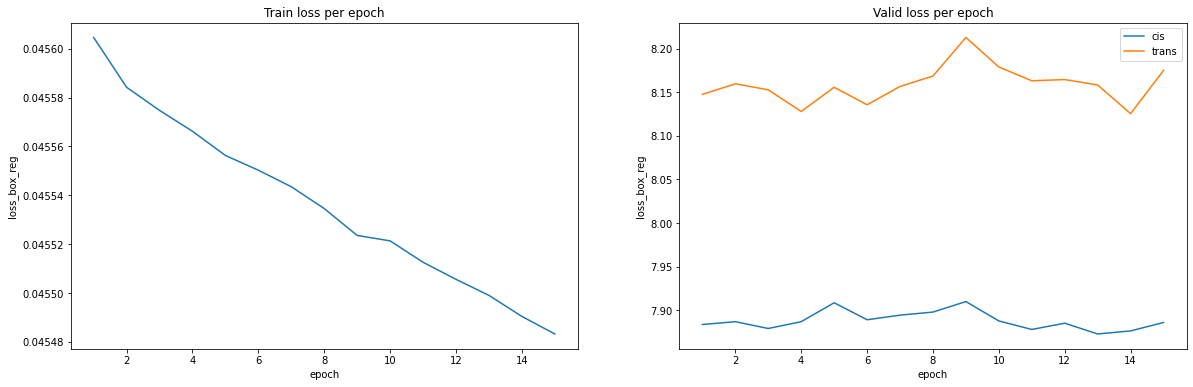

In [116]:
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(1, num_epochs + 1),train_loss_all,label='train')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')

plt.title('Train loss per epoch')
ax[1].plot(np.arange(1, num_epochs + 1),cis_loss_all, label='cis')
ax[1].plot(np.arange(1, num_epochs + 1),trans_loss_all, label='trans')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()

## Predictions

In [153]:
train_features, train_labels = next(iter(trans_valid_dataloader))
image = list(image.to(device) for image in train_features)

model.eval()
with torch.no_grad():
      pred = model(image)

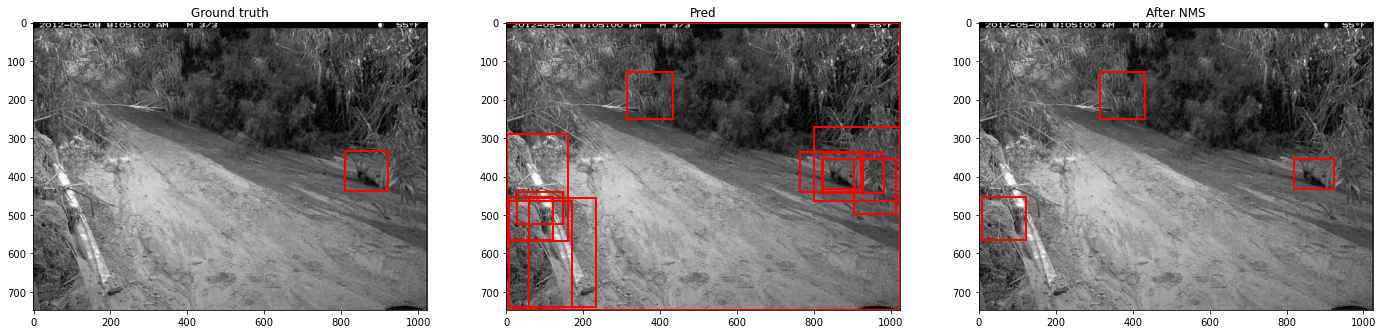

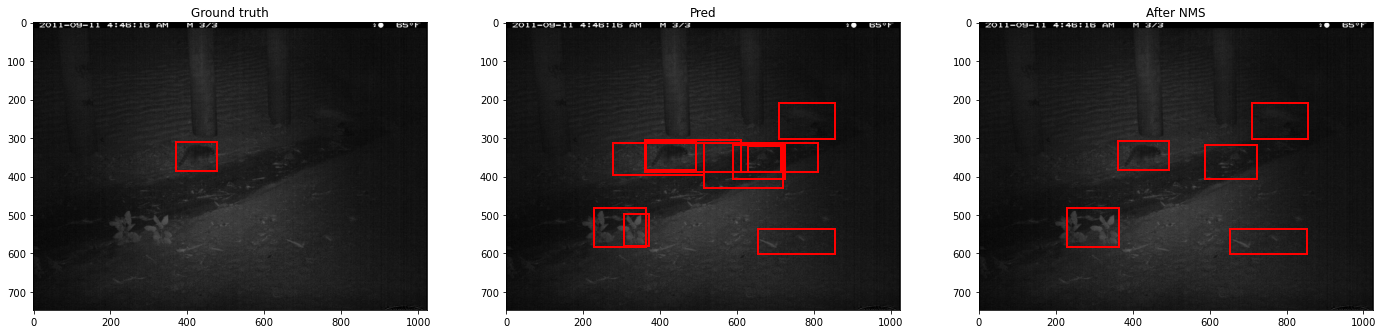

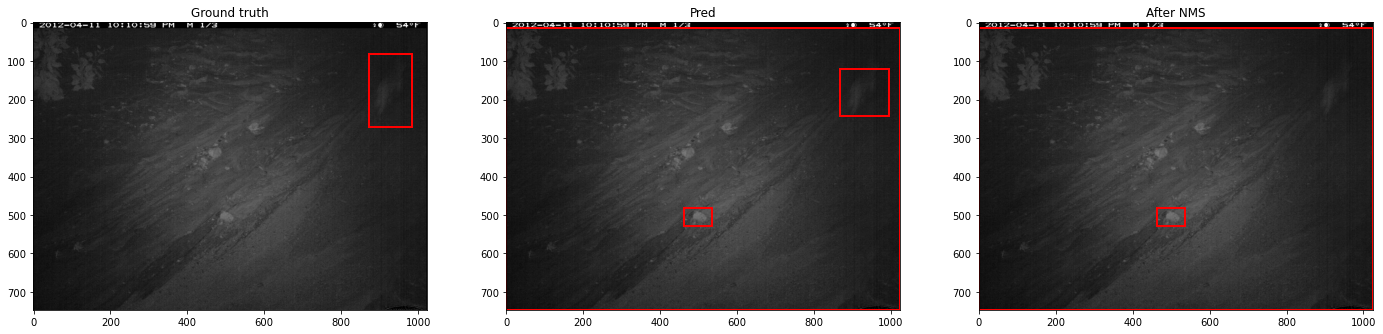

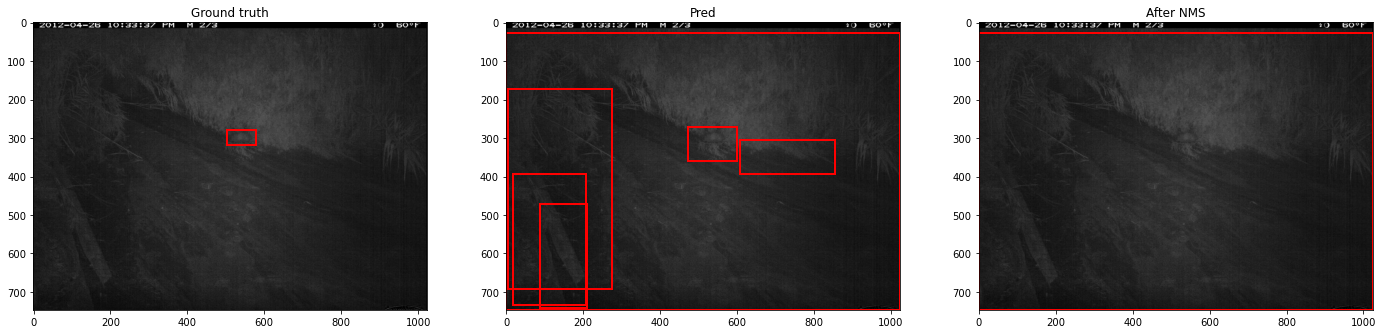

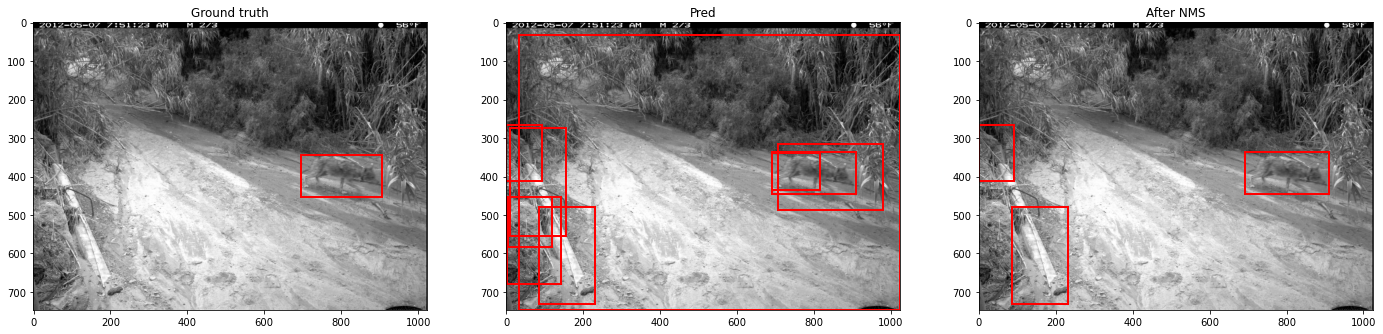

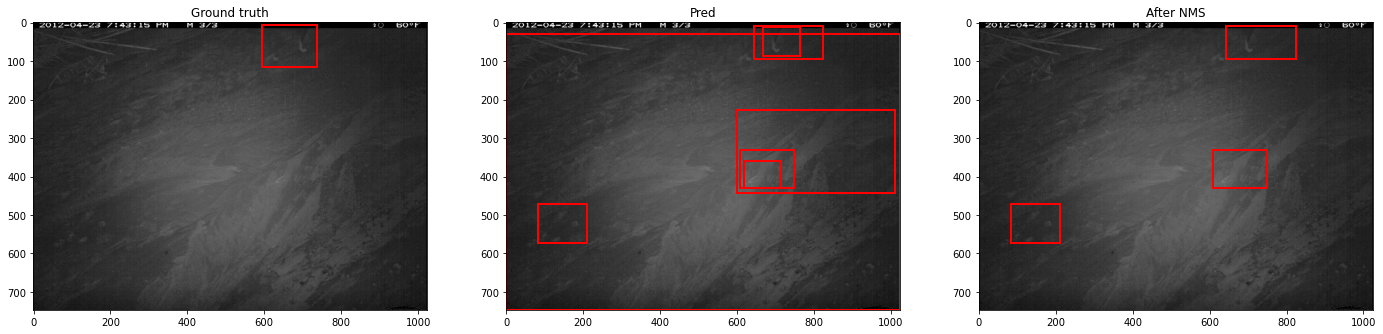

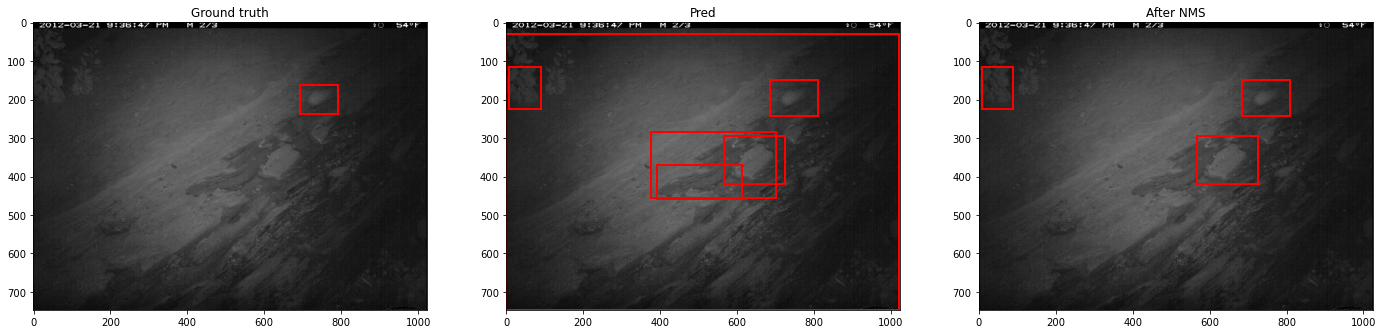

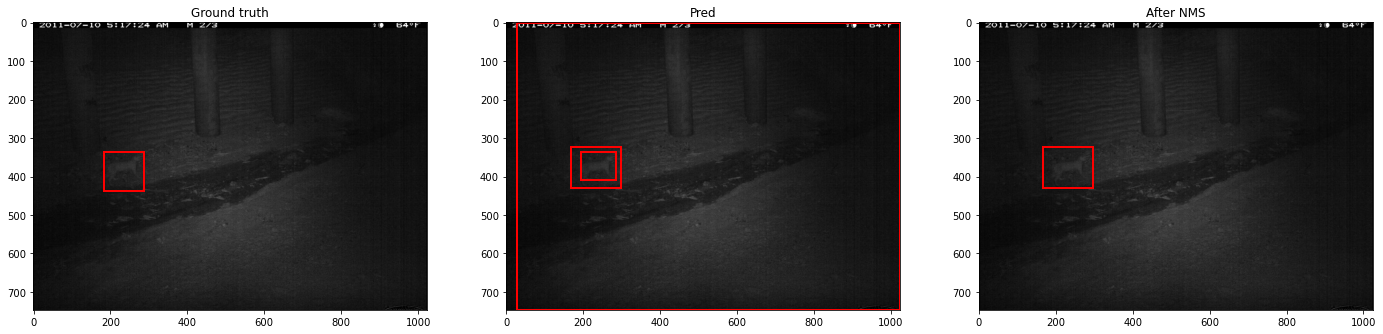

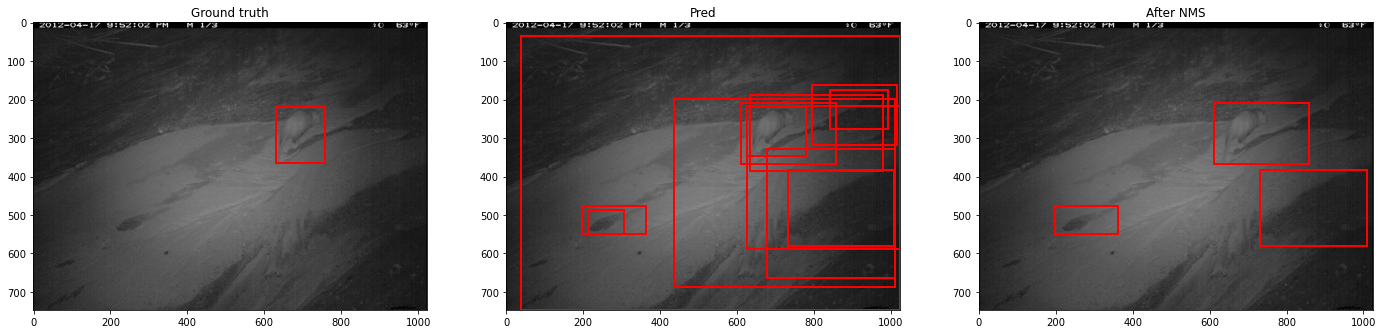

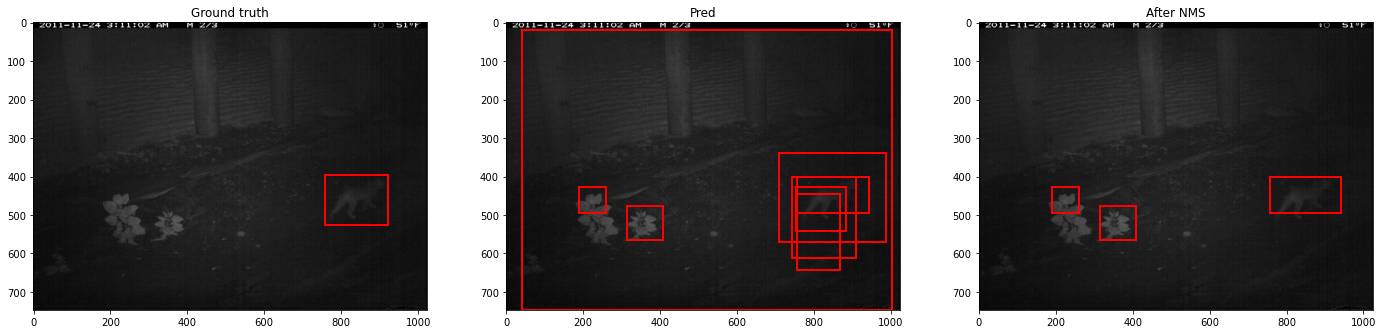

In [154]:
# Print all the images
for image_i in range(len(image)):
    fig, ax = plt.subplots(1,3,figsize=(24,16))

    ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    rect = patches.Rectangle((train_labels[image_i]['boxes'][0][0], 
                              train_labels[image_i]['boxes'][0][1]), 
                             train_labels[image_i]['boxes'][0][2]-train_labels[image_i]['boxes'][0][0], 
                             train_labels[image_i]['boxes'][0][3]-train_labels[image_i]['boxes'][0][1], 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title('Ground truth')

    # Predictions
    ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in range(len(pred[image_i]['boxes'])):
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
    ax[1].set_title('Pred')

    # Predictions after NMS
    iou_threshold = 0.01 # param to tune
    boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
    ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in boxes_to_keep:
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[2].add_patch(rect)

    ax[2].set_title('After NMS')

Text(0.5, 1.0, 'After NMS')

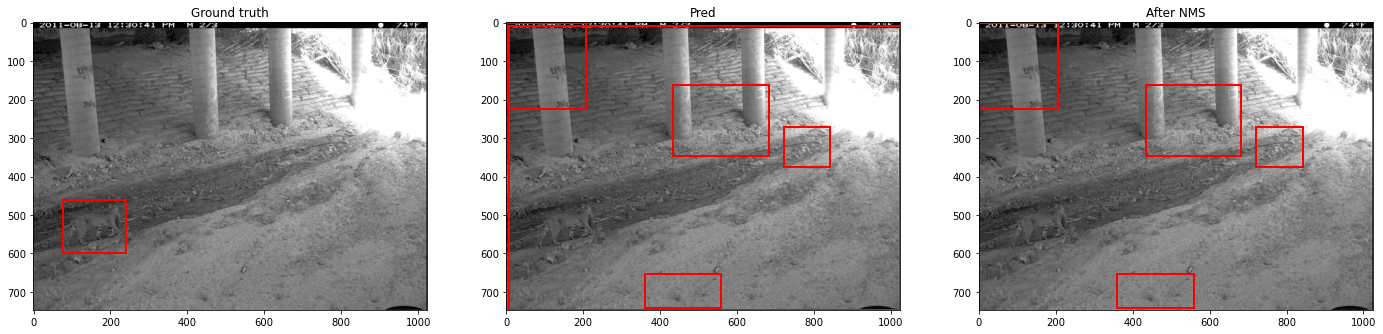

In [150]:
image_i = 0 # from 0 to 9 included

fig, ax = plt.subplots(1,3,figsize=(24,16))

ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
rect = patches.Rectangle((train_labels[image_i]['boxes'][0][0], 
                          train_labels[image_i]['boxes'][0][1]), 
                         train_labels[image_i]['boxes'][0][2]-train_labels[image_i]['boxes'][0][0], 
                         train_labels[image_i]['boxes'][0][3]-train_labels[image_i]['boxes'][0][1], 
                         linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
ax[0].set_title('Ground truth')

# Predictions
ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in range(len(pred[image_i]['boxes'])):
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
ax[1].set_title('Pred')

# Predictions after NMS
iou_threshold = 0.01 # param to tune
boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in boxes_to_keep:
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)

ax[2].set_title('After NMS')

In [161]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [144]:
boxes_to_keep

tensor([0, 1, 3, 4, 8, 9])

In [91]:
pred[image_i]['boxes'][0]

tensor([731.9652, 387.7749, 827.5851, 493.2746], device='cuda:0')

In [92]:
train_labels[image_i]['boxes']

tensor([[743., 390., 816., 490.]])

In [ ]:
# 'For evaluation, we consider a detected box to be correct if its IoU ≥ 0.5 with a ground truth box.'

## Evalutate on COCO detection metrics

In [95]:
cis_test_valid_img,_ = get_img_with_bbox(cis_test_ann_path)   # takes about 1min to run on train data
cis_test_valid_data = CustomImageDataset(cis_test_ann_path,img_folder, cis_test_valid_img)
cis_test_valid_dataloader = DataLoader(cis_test_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [96]:
trans_test_valid_img,_ = get_img_with_bbox(trans_test_ann_path)   # takes about 1min to run on train data
trans_test_valid_data = CustomImageDataset(trans_test_ann_path,img_folder, trans_test_valid_img)
trans_test_valid_dataloader = DataLoader(trans_test_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

### Cis Test

In [145]:
# Evaluate perfo on COCO detection metrics

# takes +- 25min to run on cis_test

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
from engine import _get_iou_types 

apply_nms = True
iou_threshold = 0.35 # param to potentially tune
the_data_loader = cis_test_valid_dataloader # change to test set

coco = get_coco_api_from_dataset(the_data_loader.dataset)
iou_types = _get_iou_types(model)
coco_evaluator = CocoEvaluator(coco, iou_types)

model.eval()

for images, targets in the_data_loader:
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():

        pred=model(images)

        if apply_nms:
            boxes_to_keep = torchvision.ops.nms(pred[0]['boxes'], pred[0]['scores'], iou_threshold=iou_threshold).cpu()
            pred[0]['boxes'] = pred[0]['boxes'][boxes_to_keep]
            pred[0]['labels'] = pred[0]['labels'][boxes_to_keep]
            pred[0]['scores'] = pred[0]['scores'][boxes_to_keep]

        outputs = [{k: v.cpu() for k, v in t.items()} for t in pred]
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
print('_'*20)
print('Summary')
coco_evaluator.summarize()

creating index...
index created!
Accumulating evaluation results...
DONE (t=1.93s).
____________________
Summary
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.835
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.509
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.568
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.569
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 

### Trans Test

In [162]:
# Evaluate perfo on COCO detection metrics

# takes +- 25min to run on trans_test

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
from engine import _get_iou_types 

apply_nms = True
iou_threshold = 0.35 # param to potentially tune
the_data_loader = trans_test_valid_dataloader # change to test set

coco = get_coco_api_from_dataset(the_data_loader.dataset)
iou_types = _get_iou_types(model)
coco_evaluator = CocoEvaluator(coco, iou_types)

model.eval()

for images, targets in the_data_loader:
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():

        pred=model(images)

        if apply_nms:
            boxes_to_keep = torchvision.ops.nms(pred[0]['boxes'], pred[0]['scores'], iou_threshold=iou_threshold).cpu()
            pred[0]['boxes'] = pred[0]['boxes'][boxes_to_keep]
            pred[0]['labels'] = pred[0]['labels'][boxes_to_keep]
            pred[0]['scores'] = pred[0]['scores'][boxes_to_keep]

        outputs = [{k: v.cpu() for k, v in t.items()} for t in pred]
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
print('_'*20)
print('Summary')
coco_evaluator.summarize()

creating index...
index created!
Accumulating evaluation results...
DONE (t=2.81s).
____________________
Summary
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.760
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.465
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.472
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 

## Methods